In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import time
import re
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from beautifultable import BeautifulTable
from scipy import stats
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix,classification_report,ndcg_score
from sklearn.metrics import roc_auc_score,roc_curve,auc, precision_score, recall_score, precision_recall_curve
from mlxtend.plotting import plot_confusion_matrix
from copy import deepcopy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
target_attacks={
'normal': 'normal',
'neptune': 'dos', ##denial of service
    ##, attacks that aim at make machine/network resource unavailable to intended users by overwhelming it with traffic
'satan': 'probe', ##Reconnaissance attacks where attacker scans the network for vulnerabilities(port scanning, diif srv metrics high? etc)
'ipsweep': 'probe',
'portsweep': 'probe',
'smurf': 'dos',
'nmap': 'probe',
'back': 'dos',
'teardrop': 'dos',
'warezclient':'r2l', ## remote to local, attacks where the attacker sends packets to a machine over a network to try to gain unauthorized access (shell use/root use/ dst bytes..)
'pod':'dos',
'guess_passwd':'r2l',
'buffer_overflow':'u2r', ## user to root, attacks that attempt to gain root access to a machine, often by exploiting vulnerabilities
'warezmaster':'r2l',
'land':'dos',
'imap':'r2l',
'rootkit':'u2r',
'loadmodule':'u2r',
'ftp_write':'r2l',
'multihop':'r2l',
'phf':'r2l',
'perl':'u2r',
'spy':'r2l'
}

### Important and Non-Important Features

In [4]:
#len(imp_features)+len(non_imp_features)

In [5]:
imp_features=['lastflag',
 'flag',
 'dstbytes',
 'srcbytes',
 'diffsrvrate',
 'countt',
 'dsthostsrvcount',
 'dsthostdiffsrvrate']

non_imp_features=['suattempted',
 'rootshell',
 'numfailedlogins',
 'land',
 'numfilecreations',
 'wrongfragment',
 'urgent',
 'srvdiffhostrate',
 'protocoltype',
 'isguestlogin',
 'dsthostsrvdiffhostrate',
 'dsthostcount',
 'numaccessfiles',
 'srvcount',
 'numcompromised',
 'dsthostsamesrcportrate',
 'dsthostsrvrerrorrate',
 'numroot',
 'duration',
 'hot',
 'numshells']


## decompose non important features to 5 components (figured this out in EDA ipynb file)

In [6]:
def change_to_flag(dd,cols): ##flagging some of numeric variables 
    for col in cols:
        dd.loc[:,col]=pd.Series(np.where(dd[col]==0,0,1),index=dd.index)
    return dd

def train_test(dd,x_cols,y_col,stratify_col=None):
    d=dd.copy()
    d=d.sample(frac=1,random_state=0).reset_index(drop=True)
    xtrain,xtest,ytrain,ytest=train_test_split(d.loc[:,x_cols]
                                               ,d.loc[:,y_col]
                                               ,test_size=0.08  #8% test_size
                                               ,random_state=0,stratify=stratify_col) 
    return xtrain,xtest,ytrain,ytest


def outlier_treatment_training(data,col,outlier_dict,target_var,degree_threshold=5):
    df=data.copy()
    percentiles = np.arange(0, 101, 1)

    # Calculate percentiles for the specified column
    percentile_values = np.percentile(df[col], percentiles)

    percentile_df = pd.DataFrame({
        'Percentile': percentiles,
        'Value': percentile_values
    })


    percentile_df['prev_percentile']=percentile_df['Percentile'].shift(periods=1)
    percentile_df['prev_Value']=percentile_df['Value'].shift(periods=1)
    window_size = 5

    # Get global min and max for Percentile and Value
    mean_value = percentile_df['Value'].mean()
    std_value = percentile_df['Value'].std()

    # Function to calculate slope in degrees with global min/max normalization
    def calculate_slope_degrees_normalized(values, percentiles):
        # Normalize x (Percentile) and y (Value) based on global min and max
        x_normalized = percentiles
        y_normalized = (values - mean_value) / (std_value)

        # Calculate slope of the normalized data
        slope, _ = np.polyfit(x_normalized, y_normalized, 1)

        # Convert slope to degrees
        angle_rad = np.arctan(slope)  # Convert slope to radians
        angle_deg = np.degrees(angle_rad)  # Convert radians to degrees
        return angle_deg

    # Apply rolling window to calculate slopes in degrees with normalization
    percentile_df['slope_deg'] = percentile_df['Value'].rolling(window=window_size).apply(
        lambda values: calculate_slope_degrees_normalized(values, percentile_df['Percentile'].iloc[values.index]), 
        raw=False
    )

    # Calculate the difference between consecutive slopes (in degrees) to detect changepoints
    percentile_df['slope_diff_deg'] = percentile_df['slope_deg'].diff()

    # Identify changepoints based on the threshold
    changepoint = percentile_df[(percentile_df['slope_diff_deg'].abs() >= degree_threshold)&\
                               (percentile_df['Percentile']>75)].sort_values('Percentile').prev_Value.iloc[0]
    changepoint_percentile = percentile_df[(percentile_df['slope_diff_deg'].abs() >= degree_threshold)&\
                               (percentile_df['Percentile']>75)].sort_values('Percentile').prev_percentile.iloc[0]
    df.loc[df[col]>changepoint,col]=changepoint
    outlier_dict[col]=changepoint
    print("Changepoints based on slope difference threshold:")
    print(changepoint_percentile,'(percentile) : ',changepoint)
    
    plt.figure(figsize=(12, 6))

    for label in df[target_var].unique():

        sns.kdeplot(df.loc[df[target_var]==label,col], label='{}'.format(label), palette='viridis')
    plt.title('Distribution Plot column: {}'.format(col))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return df,outlier_dict
    
    
def outlier_treatment_test(data, outlier_dict):
    df = data.copy()
    for col in outlier_dict.keys():
        try:
            cap_value = outlier_dict[col]
            df.loc[df[col] > cap_value, col] = cap_value
        except:
            pass

    return df




In [7]:
def filter_numeric(data,coll):
    enum_coll=list(enumerate(coll))
    cols=data.select_dtypes(include=['number']).columns
    cc=[]
    for col in cols:
        if (data[col].nunique(dropna=True)>2) or\
        ((sorted(list(data[col].dropna().unique()))!=[0,1]) and\
        (sorted(list(data[col].dropna().unique()))!=[0]) and\
        (sorted(list(data[col].dropna().unique()))!=[1])):
            cc.append(col)

    cols=cc
    numeric_cols=list(set(cols).intersection(set(coll)))
    li=[sett[1] for sett in enum_coll if sett[1] in numeric_cols]
    return li

def standardize_data(d,cols,strategy='standard'):
    if strategy=='standard':
        scalar=StandardScaler()
    else:
        scalar=MinMaxScaler()
    data=d.copy()
    cols=filter_numeric(data,cols)
    #print(cols)
    data.loc[:,cols]=pd.DataFrame(scalar.fit_transform(data[cols]),columns=cols,index=data.index)

    return data,scalar,cols

def transform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.transform(data[cols]),columns=cols,index=data.index)
    return data

def revtransform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.inverse_transform(data[cols]),columns=cols,index=data.index)
    return data

## One hot encoding
def dummy_str_col(d,cols):
    data=d.copy()
    drop_str_cols=[]
    str_cols=cols
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col]).astype(int)
        str_data.columns=[str_col+'_'+str(col) for col in str_data.columns]
        drop_str_cols.append(str_data.columns[-1])
        str_data.drop(str_data.columns[-1],axis=1,inplace=True)

        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)
    return data,drop_str_cols

def test_str_col(d,cols,drop_str_cols):
    data=d.copy()
    str_cols=cols
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col]).astype(int)
        str_data.columns=[str_col+'_'+str(col) for col in str_data.columns]
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)

    for drop_col in drop_str_cols:
        data.drop(drop_col,axis=1,inplace=True)
        
    return data

# WoE encoding function
def calculate_woe(data, feature, target_var):
    # Group by the feature to calculate WoE
    temp_df = data.groupby(feature)[target_var].agg(['count', 'sum'])
    temp_df['non_event'] = temp_df['count'] - temp_df['sum']
    temp_df['event_dist'] = temp_df['sum'] / temp_df['sum'].sum()
    temp_df['non_event_dist'] = temp_df['non_event'] / temp_df['non_event'].sum()
    temp_df['woe'] = np.log(temp_df['event_dist'] / temp_df['non_event_dist']).replace([np.inf, -np.inf], 0)
    
    # Return a mapping of WoE values for each category
    return temp_df['woe']

# Training function
def woe_encoding_train(df, to_encode_cols, target_var):
    d = df.copy()
    encoding_dict = {}

    for col in to_encode_cols:
        woe_values = calculate_woe(d, col, target_var)
        encoding_dict[col] = woe_values.to_dict()
        
        # Apply WoE transformation
        d[col + '_woe'] = d[col].map(encoding_dict[col]).fillna(0)
    
    return d, encoding_dict

# Test function
def woe_encoding_test(df, encoding_dict):
    d = df.copy()
    
    for col, woe_map in encoding_dict.items():
        # Assign 0 as the fallback WoE value for unseen categories
        d[col + '_woe'] = d[col].map(woe_map).fillna(0)
    
    # Drop original columns after encoding
    d.drop(columns=encoding_dict.keys(), inplace=True)
    
    return d

In [8]:
data=pd.read_csv('Network_anomaly_data_enhanced.csv')

In [9]:
data['target_attacks']=data.attack.map(target_attacks)

data['is_anamoly']=pd.Series(np.where(data['target_attacks']=='normal',0,1),index=data.index)
data['target']=data['target_attacks']
data.loc[data['target'].isin(['r2l','u2r']),'target']='other attacks'

data.rename({'count':'countt'},axis=1,inplace=True)

data=change_to_flag(data,['hot',
 'numaccessfiles',
 'numcompromised',
 'numfailedlogins',
 'numfilecreations',
 'numroot',
 'numshells',
 'suattempted',
 'urgent',
 'wrongfragment'])

data=data.loc[:,imp_features+non_imp_features+['is_anamoly','target_attacks','is_inlier','target']].copy()


test_data=data.loc[data.is_inlier==False].copy()
train_data=data.loc[data.is_inlier==True].copy()


In [10]:
target_encode={t:ind for ind,t in enumerate(data['target'].unique())}
rev_target_encode={ind:t for ind,t in enumerate(data['target'].unique())}

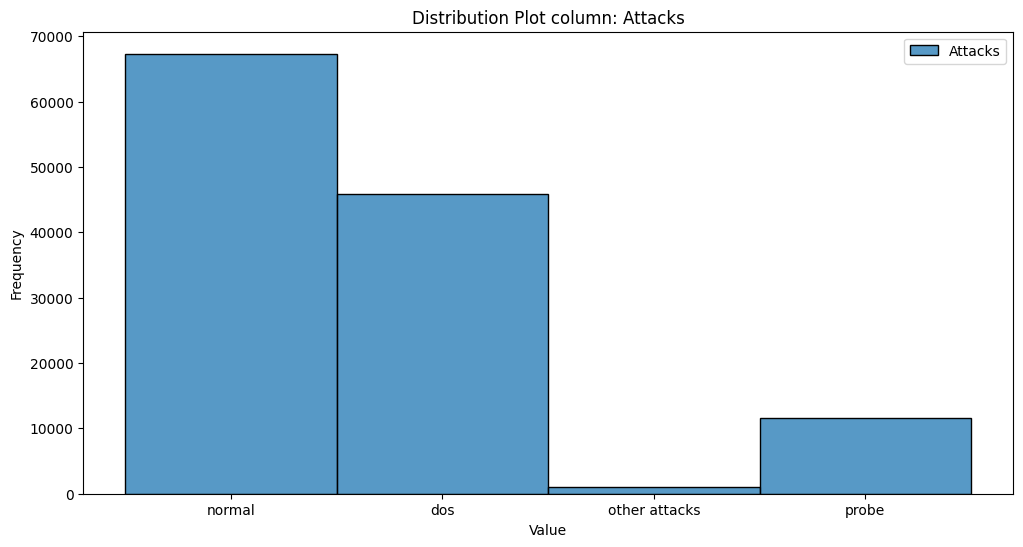

In [11]:
plt.figure(figsize=(12, 6))

sns.histplot(data.target.astype(str), label='{}'.format('Attacks'), palette='viridis')

plt.title('Distribution Plot column: {}'.format('Attacks'))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [12]:
data.target.value_counts(normalize=True)
#not unbalanced

normal           0.534583
dos              0.364578
probe            0.092528
other attacks    0.008311
Name: target, dtype: float64

In [13]:
ind=train_data.columns

stratify_col=train_data['target_attacks'].astype(str)+train_data['protocoltype'].astype(str)

xtrain,xtest,ytrain,ytest=train_test(train_data,ind,'target',stratify_col)  

xtrain.reset_index(drop=True,inplace=True)
xtest.reset_index(drop=True,inplace=True)
ytrain.reset_index(drop=True,inplace=True)
ytest.reset_index(drop=True,inplace=True)

ytest=pd.concat([ytest,test_data['target']],axis=0,ignore_index=True)
xtest=pd.concat([xtest,test_data[ind]],axis=0,ignore_index=True)

Changepoints based on slope difference threshold:
99.0 (percentile) :  627.3799999999756


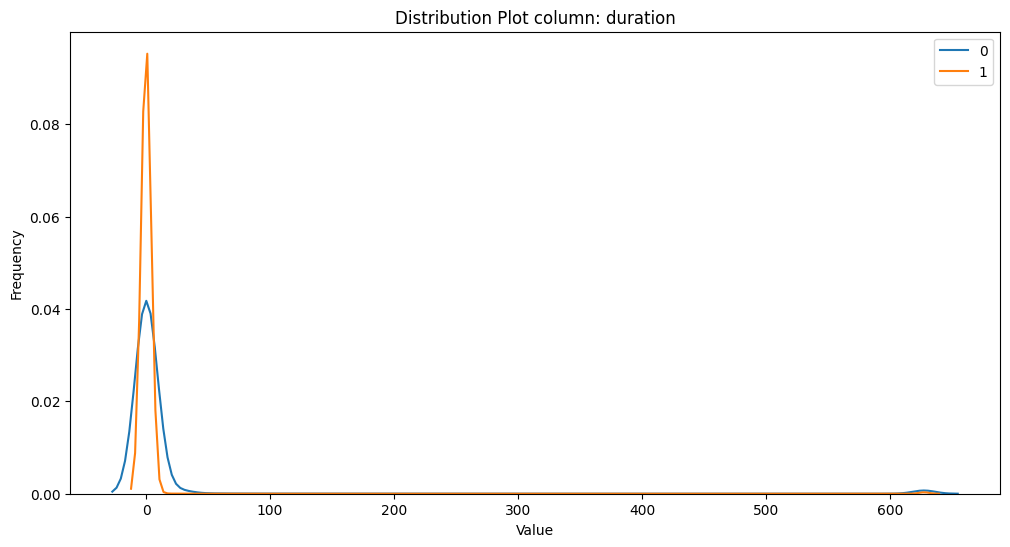

Changepoints based on slope difference threshold:
99.0 (percentile) :  47756.479999971576


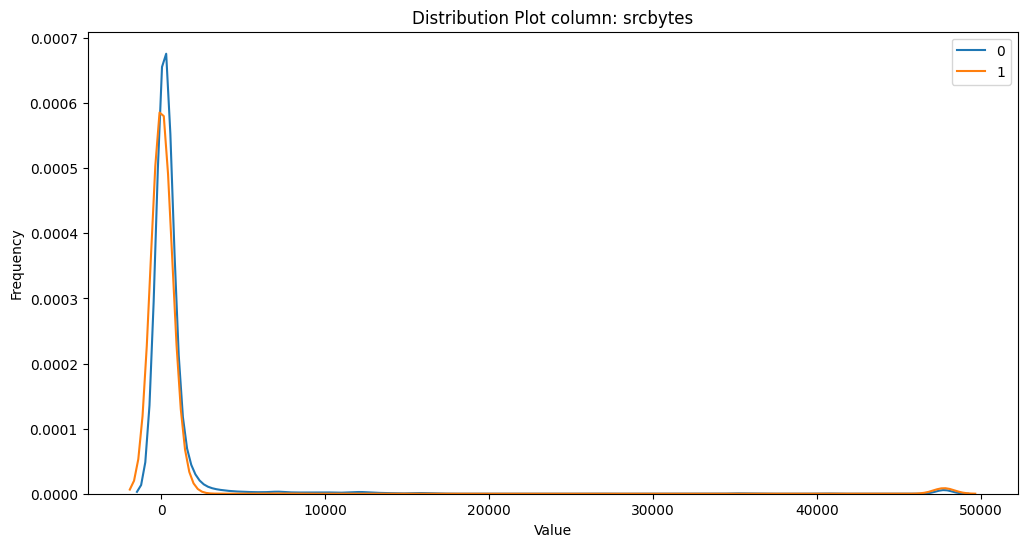

Changepoints based on slope difference threshold:
99.0 (percentile) :  23473.459999999992


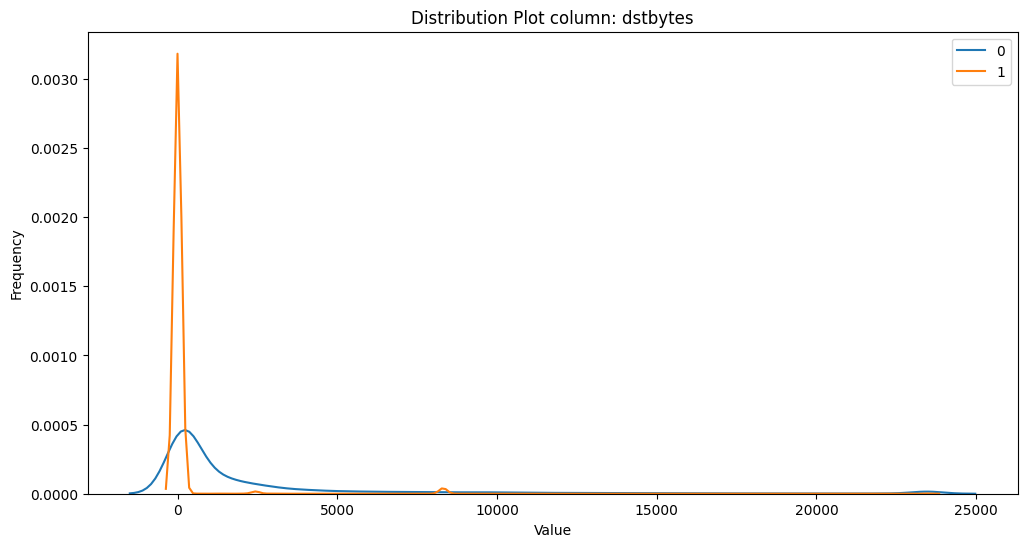

Changepoints based on slope difference threshold:
97.0 (percentile) :  299.0


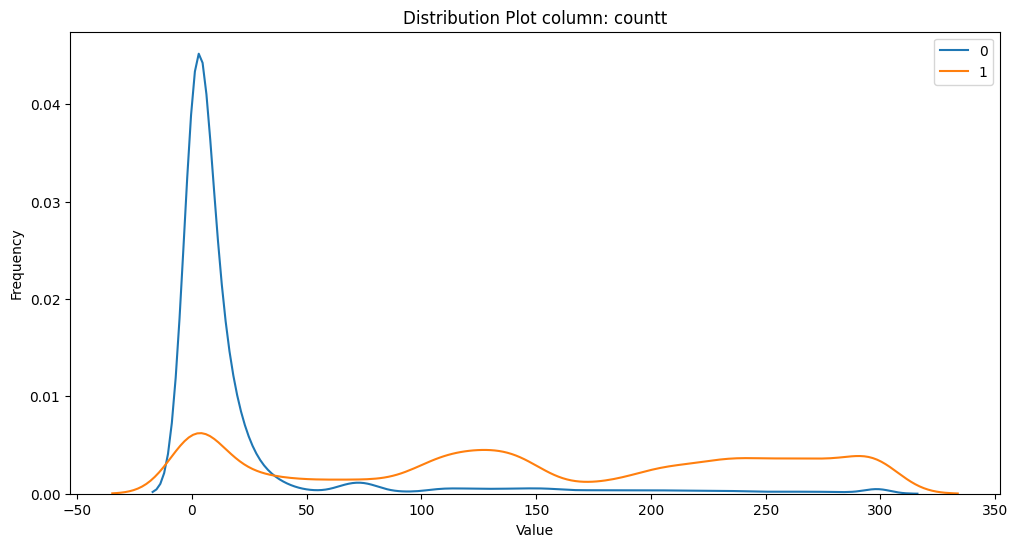

Changepoints based on slope difference threshold:
92.0 (percentile) :  70.0


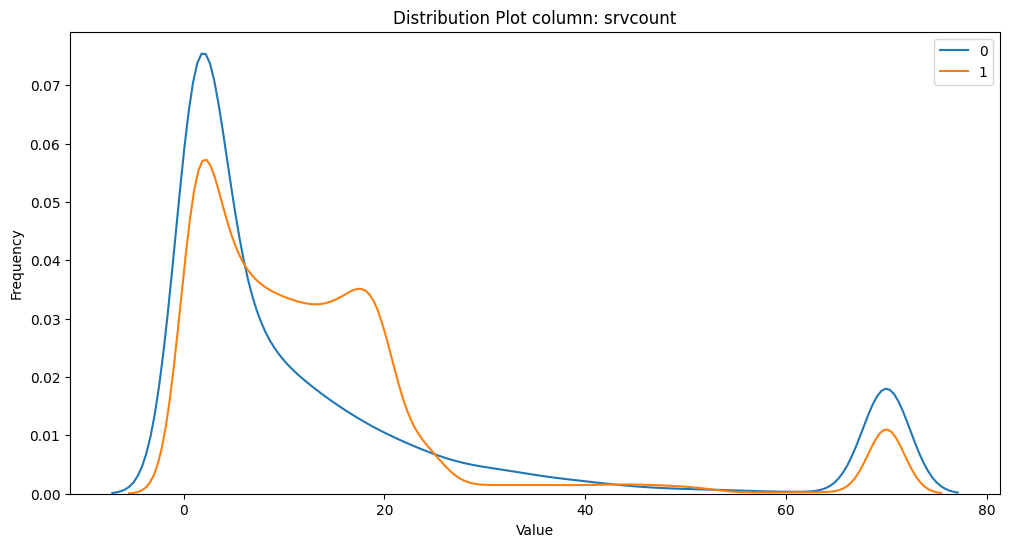

In [14]:
outlier_dict={}
for col in ['duration','srcbytes','dstbytes','countt','srvcount']:
    xtrain,outlier_dict=outlier_treatment_training(xtrain,col,outlier_dict,'is_anamoly')
    

xtest=outlier_treatment_test(xtest, outlier_dict)
    

xtrain,drop_cols=dummy_str_col(xtrain,['protocoltype'])
xtest=test_str_col(xtest,['protocoltype'],drop_cols)


xtrain,encoding_dict=woe_encoding_train(xtrain, to_encode_cols=['lastflag','flag'], target_var='is_anamoly')
xtest = woe_encoding_test(xtest, encoding_dict)


xtrain.drop(['lastflag','flag','is_anamoly','target_attacks','is_inlier','target'],axis=1,inplace=True) 
xtest.drop(['is_anamoly','target_attacks','is_inlier','target'],axis=1,inplace=True) 

xtrain,scalar,numeric_cols=standardize_data(xtrain,xtrain.columns)
xtest=transform_standardize_data(xtest,numeric_cols,scalar)

ytrain=ytrain.map(target_encode)
ytest=ytest.map(target_encode)


In [15]:
## decomposing non-important factors to 5 non-collinear components

imp_features_transformed=[]
for imp_f in imp_features:
    for ncc in xtrain.columns:
        if imp_f in ncc.split('_') and ncc not in imp_features_transformed:
            imp_features_transformed.append(ncc)
            
non_imp_features_transformed=[]
for imp_f in non_imp_features:
    for ncc in xtrain.columns:
        if imp_f in ncc.split('_') and ncc not in non_imp_features_transformed:
            non_imp_features_transformed.append(ncc)
            
            
            
i=5
pca = PCA(n_components=i,random_state=42) 

X_pca_cleaned = pca.fit_transform(xtrain[non_imp_features_transformed])
xtrain_pca=pd.DataFrame(X_pca_cleaned,columns=['col_{}'.format(j) for j in range(i)])
xtrain=pd.concat([xtrain[imp_features_transformed],xtrain_pca],axis=1)

var=np.sum(pca.explained_variance_ratio_)
print('Explained Variance: ',var)

X_pca_cleaned = pca.transform(xtest[non_imp_features_transformed])
xtest_pca=pd.DataFrame(X_pca_cleaned,columns=['col_{}'.format(j) for j in range(i)])
xtest=pd.concat([xtest[imp_features_transformed],xtest_pca],axis=1)



Explained Variance:  0.8527067030869491


### Modelling

1. False Positive (FP): A normal (non-attack) network activity is incorrectly flagged as an attack. This results in unnecessary alerts or actions on benign traffic.

2. False Negative (FN): An actual attack is incorrectly classified as normal activity. This means the attack goes undetected, potentially causing security risks.

The NDCG score is used as a performance metric to optimize the model based on the ranks of the top 2 relevant items.

In [16]:
def itertool_comb(params,estimator_pkl,key_to_ignore=['regressor','classifier']):
    param_list=[]
    for param in params:
        estimator=[value[0] for key,value in param.items() if key in key_to_ignore]
        keys=[key.split('__')[1] for key,value in param.items() if key not in key_to_ignore]
        values=[value for key,value in param.items() if key not in key_to_ignore]
        values=list(product(*values))
        iter_list=[]
        for i in range(len(values)):
            iter_dict=dict()
            for j in range(len(values[i])):
                iter_dict[keys[j]]=values[i][j]
            iter_list.append([estimator[0],iter_dict])
        for l in iter_list:
            param_list.append(l)

    par_dict={
        'param_grid':param_list,
        'checkpoint_index':0,  ##from param_list
        'best_param_index':None,
        'best_estimator':None,

        'best_val_accuracy':0,
        'best_val_ndcg': 0

        
    }

    pickle.dump(par_dict,open(estimator_pkl,'wb'))

def calculate_ndcg_score(y_true, y_pred_prob, k=10):
    ndcg_scores = []
    
    for i in range(len(y_true)):
        true_index = y_true[i]  # Use integer index directly
        
        # Sort indices by descending predicted probabilities
        sorted_indices = np.argsort(y_pred_prob.iloc[i].values)[::-1]
        
        # Relevance scores: 1 if true class is in the top k, else 0
        relevance_scores = (sorted_indices[:k] == true_index).astype(int)
        
        # Calculate DCG
        dcg = sum(rel / np.log2(j + 2) for j, rel in enumerate(relevance_scores))
        
        # Calculate IDCG (Ideal DCG)
        idcg = 1 / np.log2(2)  # True label at the top is optimal
        
        # Normalize DCG by IDCG to get NDCG
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
    
    return np.mean(ndcg_scores)

def accuracy_checks(y_true, y_pred_prob):
    
    y_true_labels = y_true.idxmax(axis=1).map({col: idx for idx, col in enumerate(y_true.columns)}).values
    y_pred= y_pred_prob.idxmax(axis=1).map({col: idx for idx, col in enumerate(y_pred_prob.columns)}).values
    
    accuracy = accuracy_score(y_true_labels, y_pred)
    conf_matrix = confusion_matrix(y_true_labels, y_pred)
    
    labels=[rev_target_encode[yy] for yy in y_true.columns]
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_true_labels, y_pred, target_names=labels))
    ndcg_score = calculate_ndcg_score(y_true_labels, y_pred_prob, k=2)
    


    print('Accuracy: {}\nNDCG score with 1st 2 relevant ranks: {}'.format(accuracy,ndcg_score))
    return accuracy,ndcg_score



def training(xtrain,ytrain,estimator_pkl,n_splits=5):

    param_dict=pickle.load(open(estimator_pkl,'rb'))
    param_grid=param_dict['param_grid']
    checkpoint_index=param_dict['checkpoint_index']  ##one already covered
    best_param_index=param_dict['best_param_index']

    best_val_accuracy=param_dict['best_val_accuracy']
    best_val_ndcg=param_dict['best_val_ndcg']
    

    ind=0
    if (checkpoint_index!=0) and (checkpoint_index!=len(param_grid)-1):
        ind=checkpoint_index+1

    while ind<len(param_grid):
        start_time=time.time()
        estimator=param_grid[ind][0]
        parameters=param_grid[ind][1]
        estimator.set_params(**parameters)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        smote = SMOTE(random_state=42)

        stratify_col=ytrain.astype(str)


        # Perform Stratified K-Fold Cross-Validation
        fold = 0
        accuracies = []
        ndcgs=[]


        print('Iteration:',ind+1)
        print(str(estimator))
        print('=========================Training in Folds===========================')
        for train_index, test_index in skf.split(xtrain, stratify_col):
            fold += 1
            print('============Fold {}============='.format(fold))
            X_train, X_val = xtrain.iloc[train_index], xtrain.iloc[test_index]
            y_train, y_val = ytrain.iloc[train_index], ytrain.iloc[test_index]
            X_train.reset_index(drop=True,inplace=True)
            X_val.reset_index(drop=True,inplace=True)
            y_train.reset_index(drop=True,inplace=True)
            y_val.reset_index(drop=True,inplace=True)


            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

            estimator.fit(X_train_resampled,y_train_resampled)
            ypred_train_prob=pd.DataFrame(estimator.predict_proba(X_train_resampled),columns=estimator.classes_)
            ypred_val_prob=pd.DataFrame(estimator.predict_proba(X_val),columns=estimator.classes_)
            
            y_train_encoded = pd.get_dummies(y_train_resampled).astype(int)
            y_test_encoded = pd.get_dummies(y_val).astype(int)
            
            print('==========================Train metrics================================')
            _,_=accuracy_checks(y_train_encoded,ypred_train_prob)
            
            print('==========================Val metrics================================')
            val_accuracy,val_ndcg=accuracy_checks(y_test_encoded,ypred_val_prob)

            accuracies.append(val_accuracy)
            ndcgs.append(val_ndcg)
            



        print('==========================End of Folds================================')
        acc=sum(accuracies)/n_splits
        ndcg=sum(ndcgs)/n_splits
        


        if ndcg>best_val_ndcg:
            param_dict['best_param_index']=ind
            param_dict['best_estimator']=deepcopy(estimator)

            param_dict['best_val_accuracy']=acc
            param_dict['best_val_ndcg']=ndcg
            



        param_dict['checkpoint_index']=ind
        print('========================================================================')
        print('time taken(mins): ',(time.time()-start_time)/60)
        print("param_dict[best_estimator]: ",param_dict['best_estimator'])
        print("param_dict[best_val_accuracy]: ",param_dict['best_val_accuracy'])
        print("param_dict[best_val_ndcg]: ",param_dict['best_val_ndcg'])

        print('========================================================================')

        pickle.dump(param_dict,open(estimator_pkl,'wb'))

        checkpoint_index=param_dict['checkpoint_index']
        best_param_index=param_dict['best_param_index']
        best_val_accuracy=param_dict['best_val_accuracy']
        best_val_ndcg=param_dict['best_val_ndcg']


        ind+=1
        
def find_best_model(estimator_pkl,xtrain,ytrain,xtest,ytest,n_splits,is_first):

    ##creating pickle file first time
    if is_first:
        itertool_comb(param,estimator_pkl)

    training(xtrain,ytrain,estimator_pkl,n_splits)

Iteration: 1
RandomForestClassifier(max_depth=3, n_estimators=200, oob_score=True)
=========================Training in Folds===========================
============Fold 1=============
==========================Train metrics================================


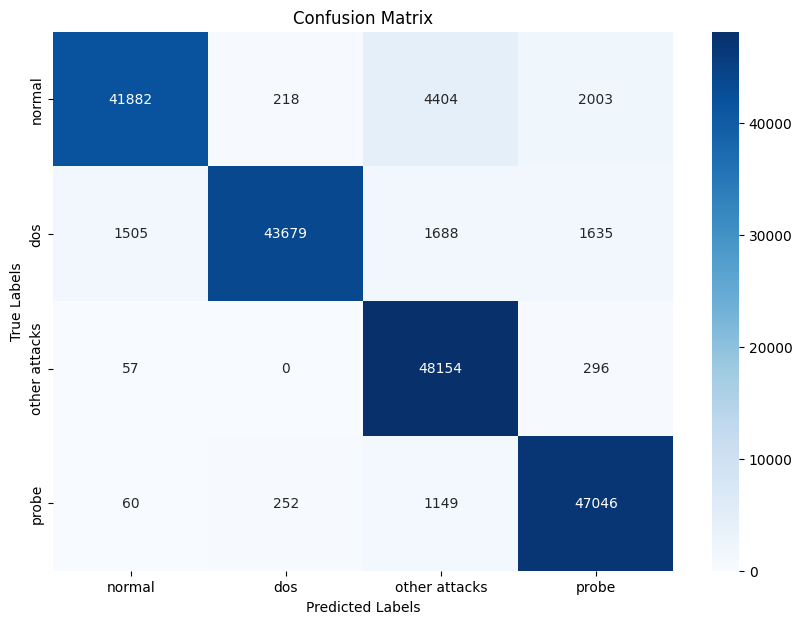

Classification Report:
               precision    recall  f1-score   support

       normal       0.96      0.86      0.91     48507
          dos       0.99      0.90      0.94     48507
other attacks       0.87      0.99      0.93     48507
        probe       0.92      0.97      0.95     48507

     accuracy                           0.93    194028
    macro avg       0.94      0.93      0.93    194028
 weighted avg       0.94      0.93      0.93    194028

Accuracy: 0.9316232708681221
NDCG score with 1st 2 relevant ranks: 0.9596045443414476
==========================Val metrics================================


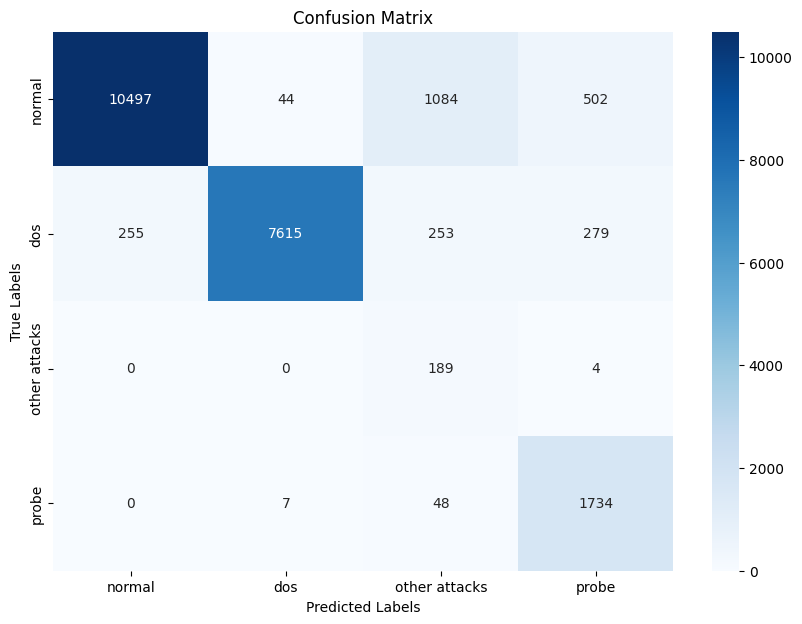

Classification Report:
               precision    recall  f1-score   support

       normal       0.98      0.87      0.92     12127
          dos       0.99      0.91      0.95      8402
other attacks       0.12      0.98      0.21       193
        probe       0.69      0.97      0.81      1789

     accuracy                           0.89     22511
    macro avg       0.69      0.93      0.72     22511
 weighted avg       0.95      0.89      0.91     22511

Accuracy: 0.8900093287726001
NDCG score with 1st 2 relevant ranks: 0.9362549017543824
============Fold 2=============
==========================Train metrics================================


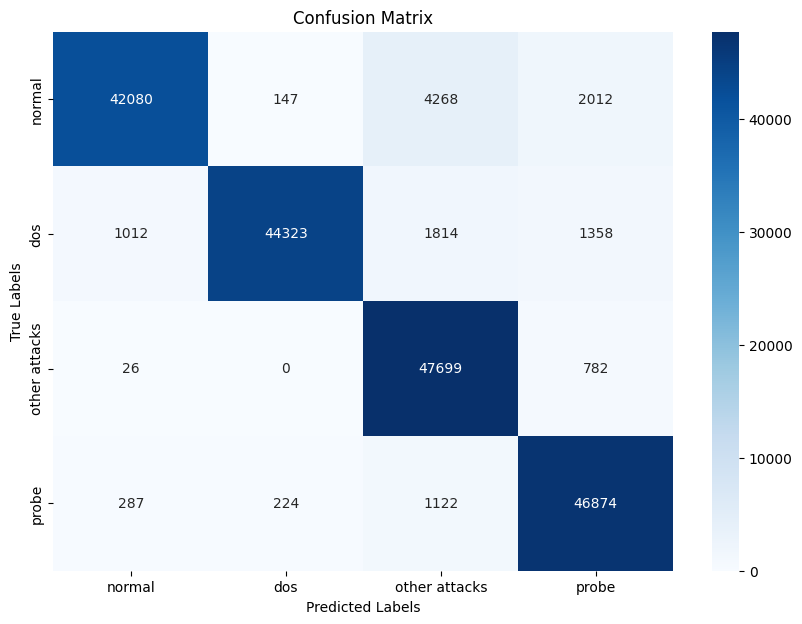

Classification Report:
               precision    recall  f1-score   support

       normal       0.97      0.87      0.92     48507
          dos       0.99      0.91      0.95     48507
other attacks       0.87      0.98      0.92     48507
        probe       0.92      0.97      0.94     48507

     accuracy                           0.93    194028
    macro avg       0.94      0.93      0.93    194028
 weighted avg       0.94      0.93      0.93    194028

Accuracy: 0.932731358360649
NDCG score with 1st 2 relevant ranks: 0.9623287495464953
==========================Val metrics================================


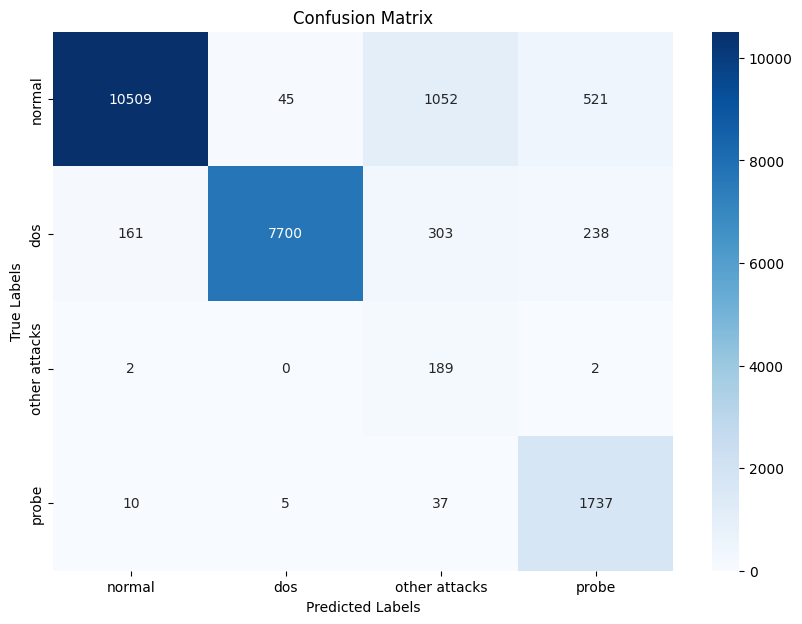

Classification Report:
               precision    recall  f1-score   support

       normal       0.98      0.87      0.92     12127
          dos       0.99      0.92      0.95      8402
other attacks       0.12      0.98      0.21       193
        probe       0.70      0.97      0.81      1789

     accuracy                           0.89     22511
    macro avg       0.70      0.93      0.72     22511
 weighted avg       0.96      0.89      0.92     22511

Accuracy: 0.8944516014392964
NDCG score with 1st 2 relevant ranks: 0.9427992459202508
============Fold 3=============
==========================Train metrics================================


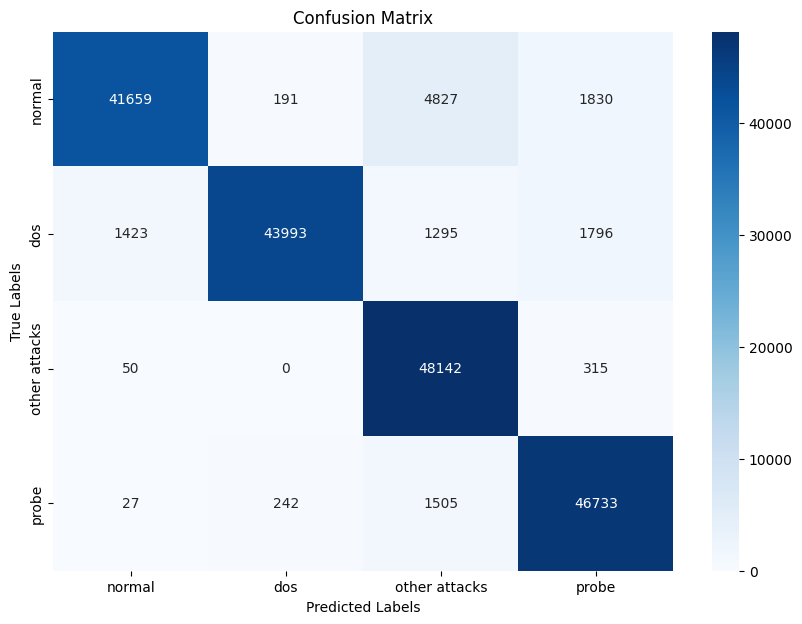

Classification Report:
               precision    recall  f1-score   support

       normal       0.97      0.86      0.91     48507
          dos       0.99      0.91      0.95     48507
other attacks       0.86      0.99      0.92     48507
        probe       0.92      0.96      0.94     48507

     accuracy                           0.93    194028
    macro avg       0.94      0.93      0.93    194028
 weighted avg       0.94      0.93      0.93    194028

Accuracy: 0.9304172593646278
NDCG score with 1st 2 relevant ranks: 0.9587367144115995
==========================Val metrics================================


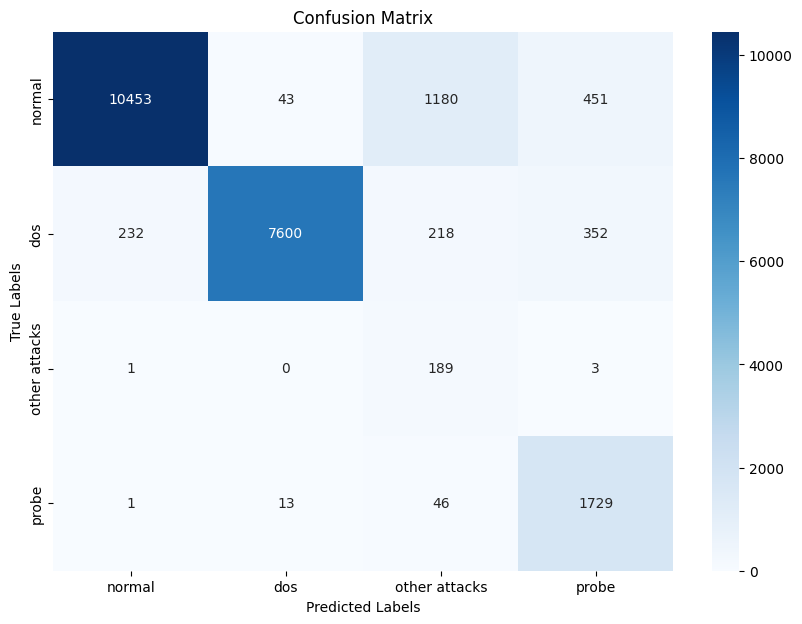

Classification Report:
               precision    recall  f1-score   support

       normal       0.98      0.86      0.92     12127
          dos       0.99      0.90      0.95      8402
other attacks       0.12      0.98      0.21       193
        probe       0.68      0.97      0.80      1789

     accuracy                           0.89     22511
    macro avg       0.69      0.93      0.72     22511
 weighted avg       0.95      0.89      0.91     22511

Accuracy: 0.8871662742659144
NDCG score with 1st 2 relevant ranks: 0.9346170349072221
============Fold 4=============
==========================Train metrics================================


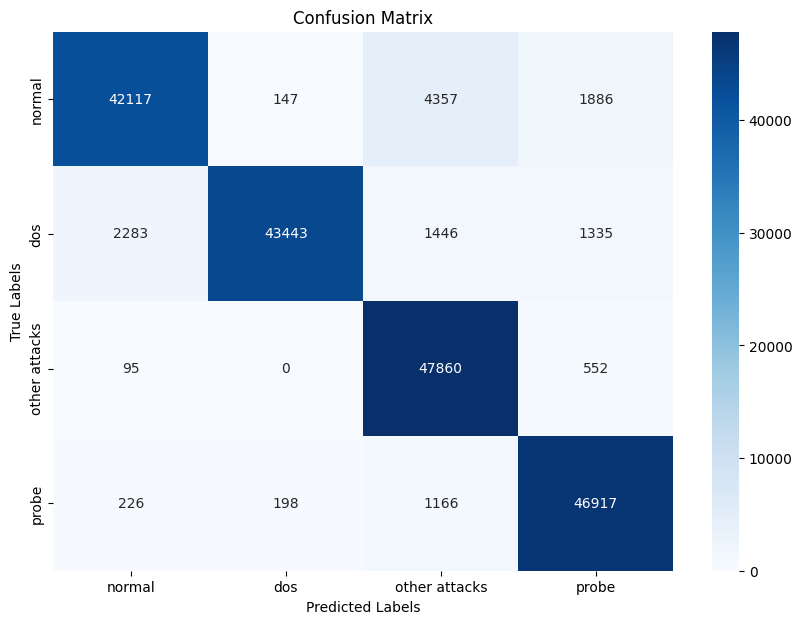

Classification Report:
               precision    recall  f1-score   support

       normal       0.94      0.87      0.90     48507
          dos       0.99      0.90      0.94     48507
other attacks       0.87      0.99      0.93     48507
        probe       0.93      0.97      0.95     48507

     accuracy                           0.93    194028
    macro avg       0.93      0.93      0.93    194028
 weighted avg       0.93      0.93      0.93    194028

Accuracy: 0.9294380192549528
NDCG score with 1st 2 relevant ranks: 0.9607198148172297
==========================Val metrics================================


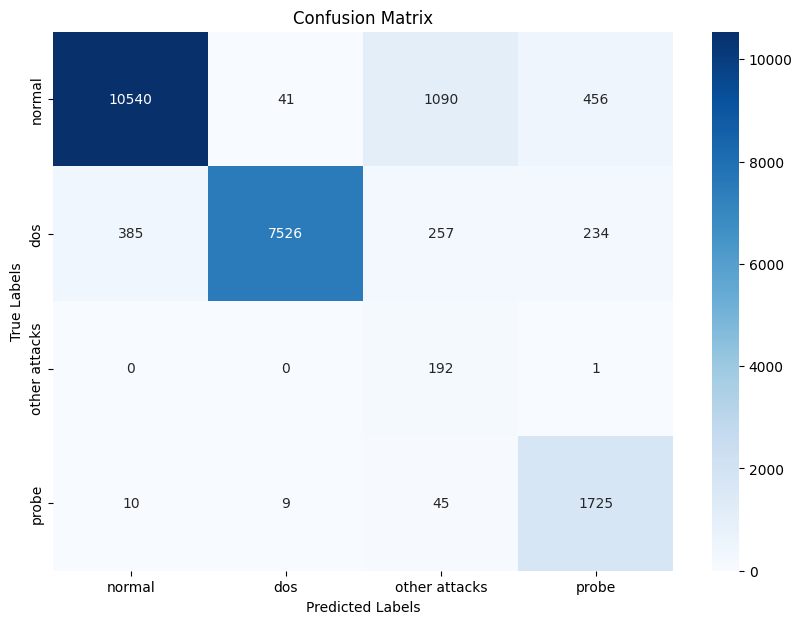

Classification Report:
               precision    recall  f1-score   support

       normal       0.96      0.87      0.91     12127
          dos       0.99      0.90      0.94      8402
other attacks       0.12      0.99      0.22       193
        probe       0.71      0.96      0.82      1789

     accuracy                           0.89     22511
    macro avg       0.70      0.93      0.72     22511
 weighted avg       0.95      0.89      0.91     22511

Accuracy: 0.887699346985918
NDCG score with 1st 2 relevant ranks: 0.9383452563059671
============Fold 5=============
==========================Train metrics================================


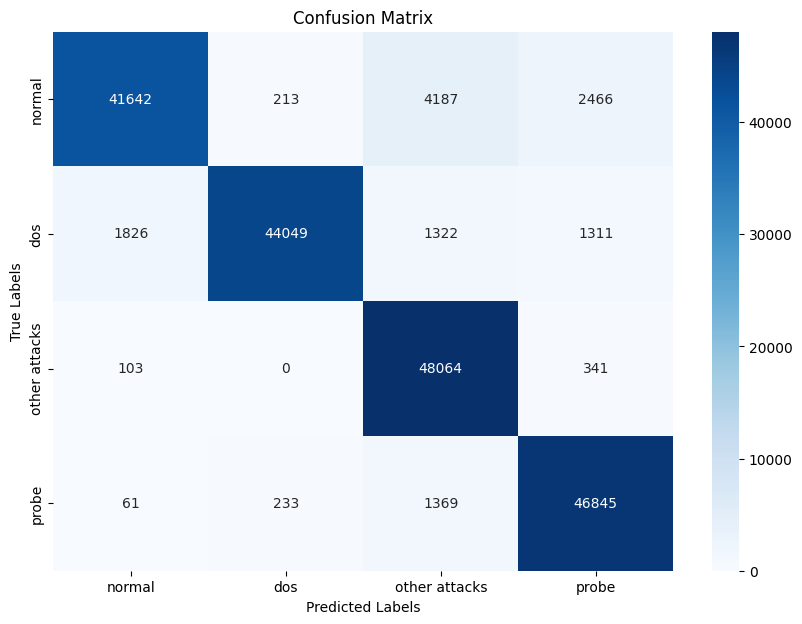

Classification Report:
               precision    recall  f1-score   support

       normal       0.95      0.86      0.90     48508
          dos       0.99      0.91      0.95     48508
other attacks       0.87      0.99      0.93     48508
        probe       0.92      0.97      0.94     48508

     accuracy                           0.93    194032
    macro avg       0.93      0.93      0.93    194032
 weighted avg       0.93      0.93      0.93    194032

Accuracy: 0.930774305269234
NDCG score with 1st 2 relevant ranks: 0.9617985733220565
==========================Val metrics================================


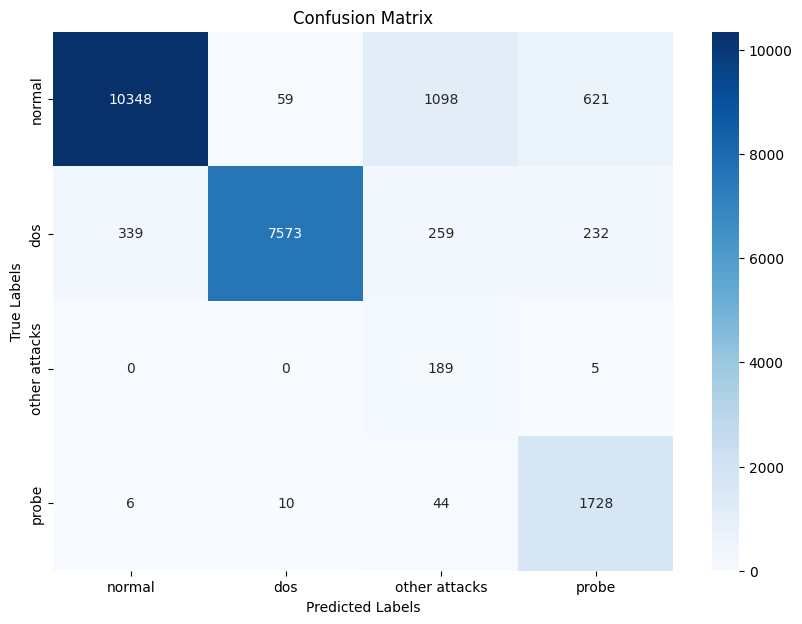

Classification Report:
               precision    recall  f1-score   support

       normal       0.97      0.85      0.91     12126
          dos       0.99      0.90      0.94      8403
other attacks       0.12      0.97      0.21       194
        probe       0.67      0.97      0.79      1788

     accuracy                           0.88     22511
    macro avg       0.69      0.92      0.71     22511
 weighted avg       0.95      0.88      0.91     22511

Accuracy: 0.8812580516192083
NDCG score with 1st 2 relevant ranks: 0.9356596620177781
==========================End of Folds================================
time taken(mins):  2.7177982091903687
param_dict[best_estimator]:  RandomForestClassifier(max_depth=3, n_estimators=200, oob_score=True)
param_dict[best_val_accuracy]:  0.8881169206165875
param_dict[best_val_ndcg]:  0.93753522018112
Iteration: 2
RandomForestClassifier(max_depth=5, n_estimators=200, oob_score=True)
=========================Training in Folds===================

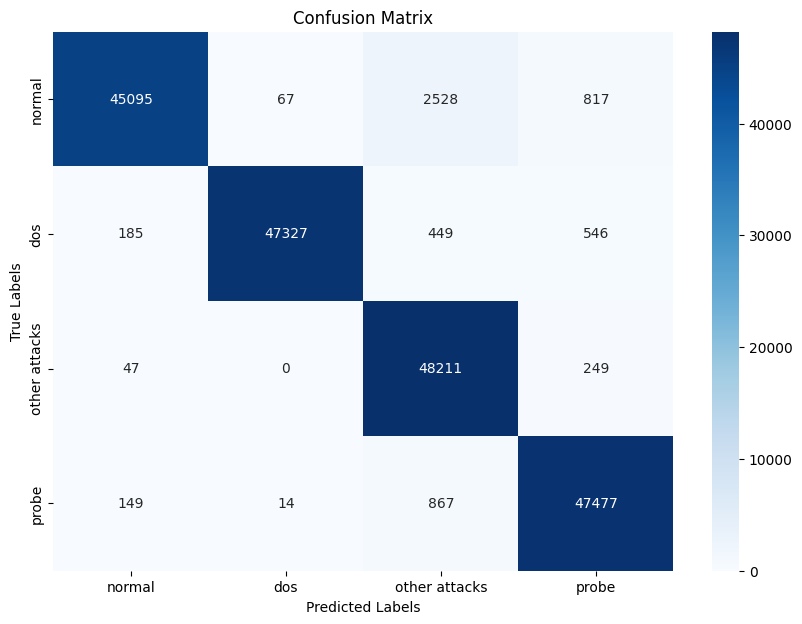

Classification Report:
               precision    recall  f1-score   support

       normal       0.99      0.93      0.96     48507
          dos       1.00      0.98      0.99     48507
other attacks       0.93      0.99      0.96     48507
        probe       0.97      0.98      0.97     48507

     accuracy                           0.97    194028
    macro avg       0.97      0.97      0.97    194028
 weighted avg       0.97      0.97      0.97    194028

Accuracy: 0.9694992475312841
NDCG score with 1st 2 relevant ranks: 0.9849905650010021
==========================Val metrics================================


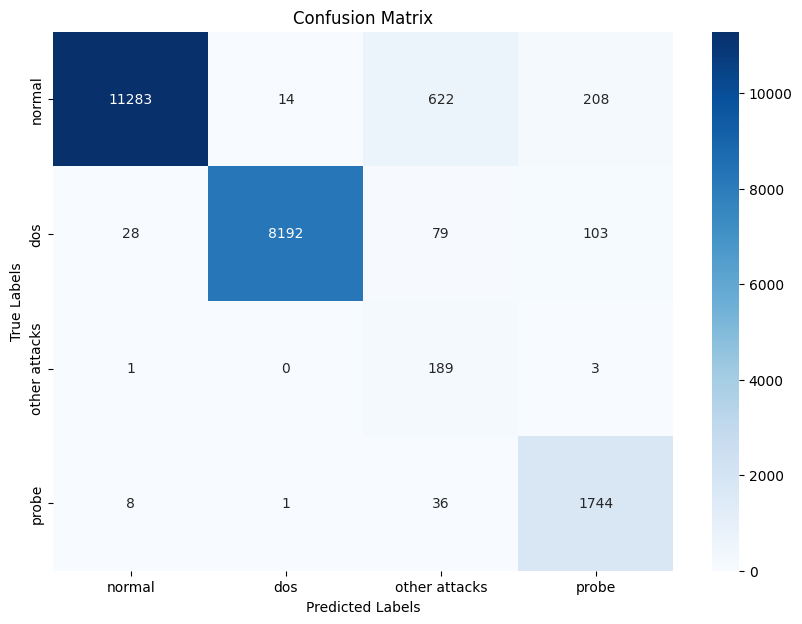

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.93      0.96     12127
          dos       1.00      0.98      0.99      8402
other attacks       0.20      0.98      0.34       193
        probe       0.85      0.97      0.91      1789

     accuracy                           0.95     22511
    macro avg       0.76      0.96      0.80     22511
 weighted avg       0.98      0.95      0.96     22511

Accuracy: 0.95100173248634
NDCG score with 1st 2 relevant ranks: 0.977740081955807
============Fold 2=============
==========================Train metrics================================


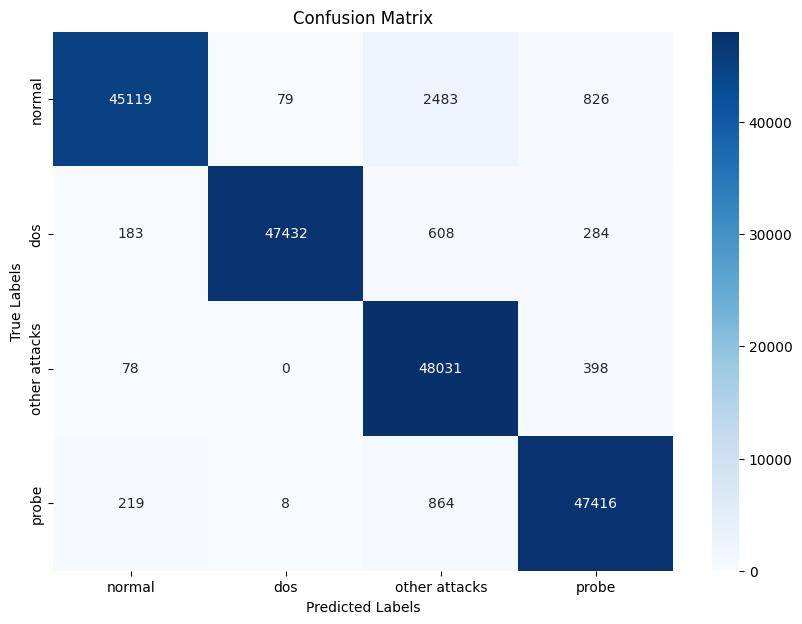

Classification Report:
               precision    recall  f1-score   support

       normal       0.99      0.93      0.96     48507
          dos       1.00      0.98      0.99     48507
other attacks       0.92      0.99      0.96     48507
        probe       0.97      0.98      0.97     48507

     accuracy                           0.97    194028
    macro avg       0.97      0.97      0.97    194028
 weighted avg       0.97      0.97      0.97    194028

Accuracy: 0.9689220112561073
NDCG score with 1st 2 relevant ranks: 0.9851254610780227
==========================Val metrics================================


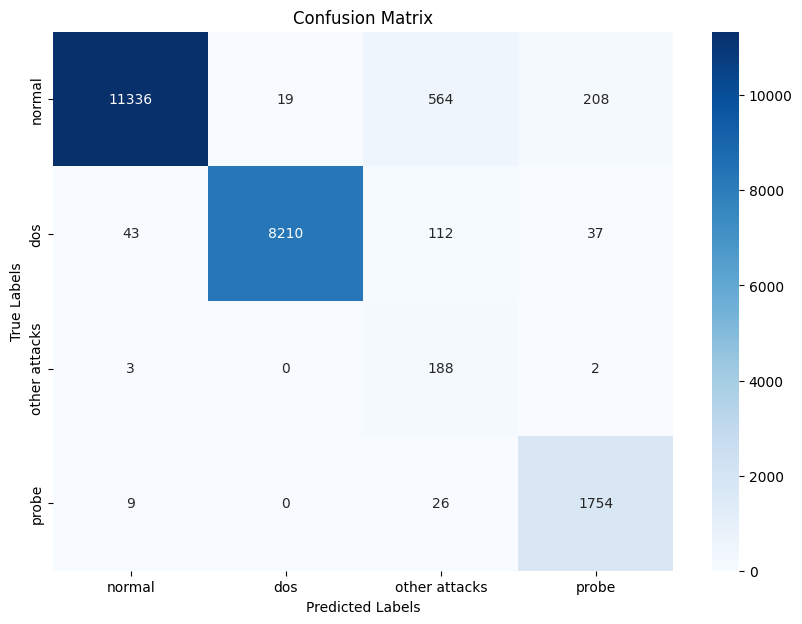

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.93      0.96     12127
          dos       1.00      0.98      0.99      8402
other attacks       0.21      0.97      0.35       193
        probe       0.88      0.98      0.93      1789

     accuracy                           0.95     22511
    macro avg       0.77      0.97      0.81     22511
 weighted avg       0.98      0.95      0.96     22511

Accuracy: 0.954555550619697
NDCG score with 1st 2 relevant ranks: 0.9794160495499037
============Fold 3=============
==========================Train metrics================================


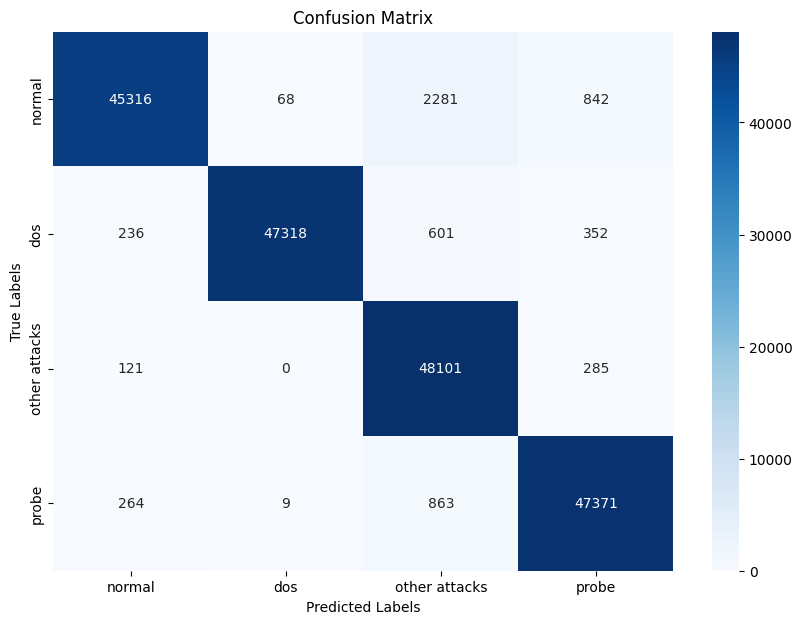

Classification Report:
               precision    recall  f1-score   support

       normal       0.99      0.93      0.96     48507
          dos       1.00      0.98      0.99     48507
other attacks       0.93      0.99      0.96     48507
        probe       0.97      0.98      0.97     48507

     accuracy                           0.97    194028
    macro avg       0.97      0.97      0.97    194028
 weighted avg       0.97      0.97      0.97    194028

Accuracy: 0.9694786319500278
NDCG score with 1st 2 relevant ranks: 0.9847976068870223
==========================Val metrics================================


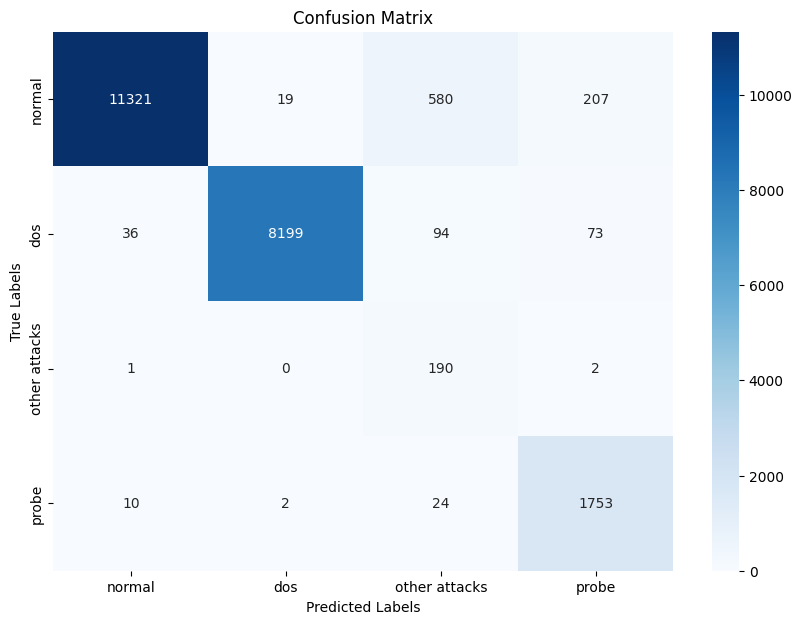

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.93      0.96     12127
          dos       1.00      0.98      0.99      8402
other attacks       0.21      0.98      0.35       193
        probe       0.86      0.98      0.92      1789

     accuracy                           0.95     22511
    macro avg       0.77      0.97      0.80     22511
 weighted avg       0.98      0.95      0.96     22511

Accuracy: 0.953444982453023
NDCG score with 1st 2 relevant ranks: 0.9790061718829537
============Fold 4=============
==========================Train metrics================================


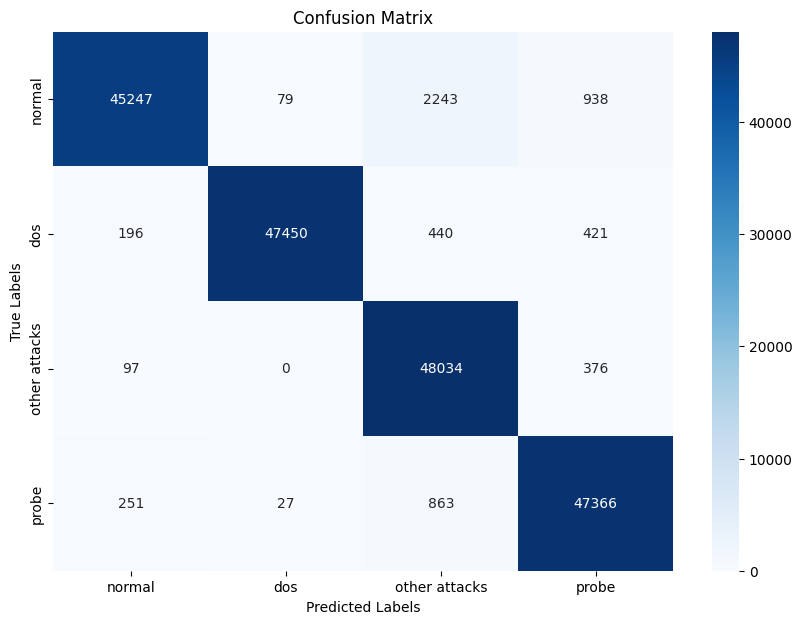

Classification Report:
               precision    recall  f1-score   support

       normal       0.99      0.93      0.96     48507
          dos       1.00      0.98      0.99     48507
other attacks       0.93      0.99      0.96     48507
        probe       0.96      0.98      0.97     48507

     accuracy                           0.97    194028
    macro avg       0.97      0.97      0.97    194028
 weighted avg       0.97      0.97      0.97    194028

Accuracy: 0.9694322468922011
NDCG score with 1st 2 relevant ranks: 0.9850016062635297
==========================Val metrics================================


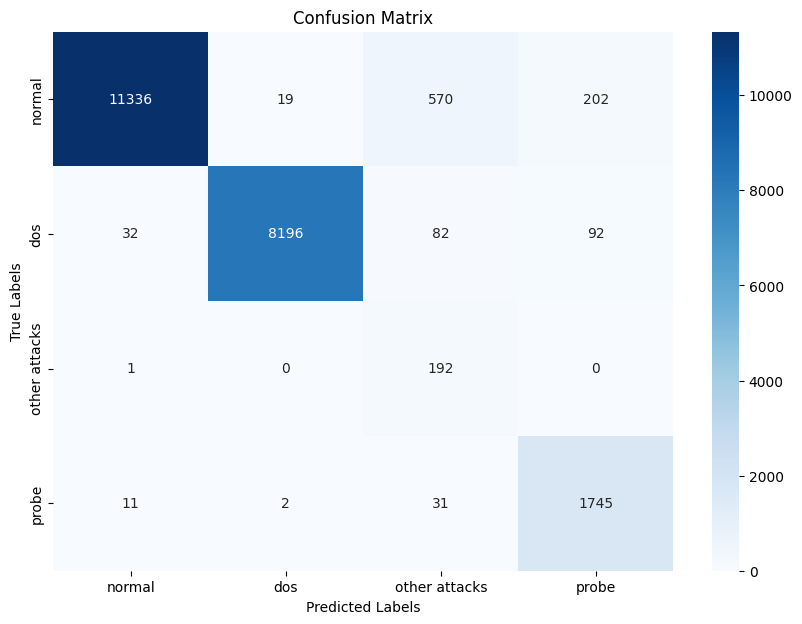

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.93      0.96     12127
          dos       1.00      0.98      0.99      8402
other attacks       0.22      0.99      0.36       193
        probe       0.86      0.98      0.91      1789

     accuracy                           0.95     22511
    macro avg       0.77      0.97      0.81     22511
 weighted avg       0.98      0.95      0.96     22511

Accuracy: 0.9537115188130247
NDCG score with 1st 2 relevant ranks: 0.9783758244033087
============Fold 5=============
==========================Train metrics================================


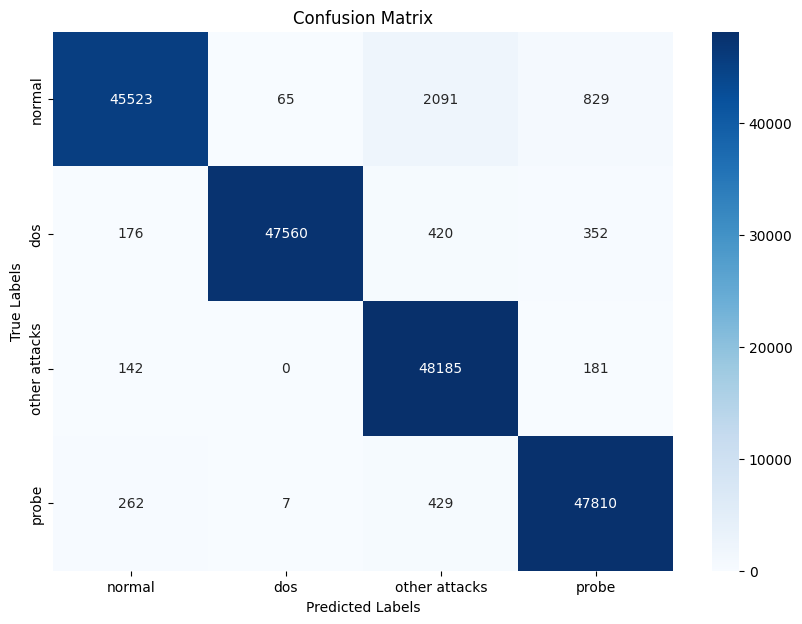

Classification Report:
               precision    recall  f1-score   support

       normal       0.99      0.94      0.96     48508
          dos       1.00      0.98      0.99     48508
other attacks       0.94      0.99      0.97     48508
        probe       0.97      0.99      0.98     48508

     accuracy                           0.97    194032
    macro avg       0.98      0.97      0.97    194032
 weighted avg       0.98      0.97      0.97    194032

Accuracy: 0.9744681289684176
NDCG score with 1st 2 relevant ranks: 0.9876797001977037
==========================Val metrics================================


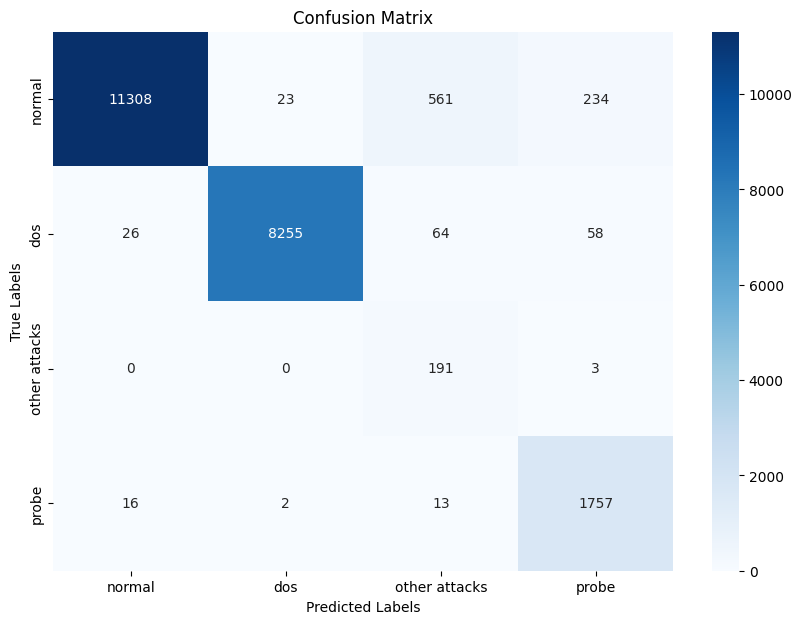

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.93      0.96     12126
          dos       1.00      0.98      0.99      8403
other attacks       0.23      0.98      0.37       194
        probe       0.86      0.98      0.92      1788

     accuracy                           0.96     22511
    macro avg       0.77      0.97      0.81     22511
 weighted avg       0.98      0.96      0.96     22511

Accuracy: 0.9555772733330372
NDCG score with 1st 2 relevant ranks: 0.9795408884235972
==========================End of Folds================================
time taken(mins):  3.36481104294459
param_dict[best_estimator]:  RandomForestClassifier(max_depth=5, n_estimators=200, oob_score=True)
param_dict[best_val_accuracy]:  0.9536582115410244
param_dict[best_val_ndcg]:  0.978815803243114
Iteration: 3
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
          

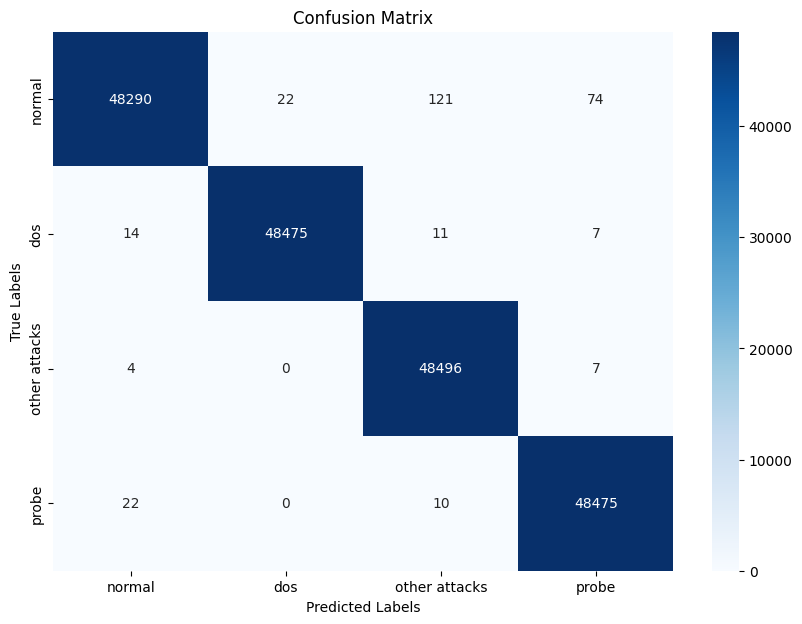

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9984950625682891
NDCG score with 1st 2 relevant ranks: 0.9993372647565042
==========================Val metrics================================


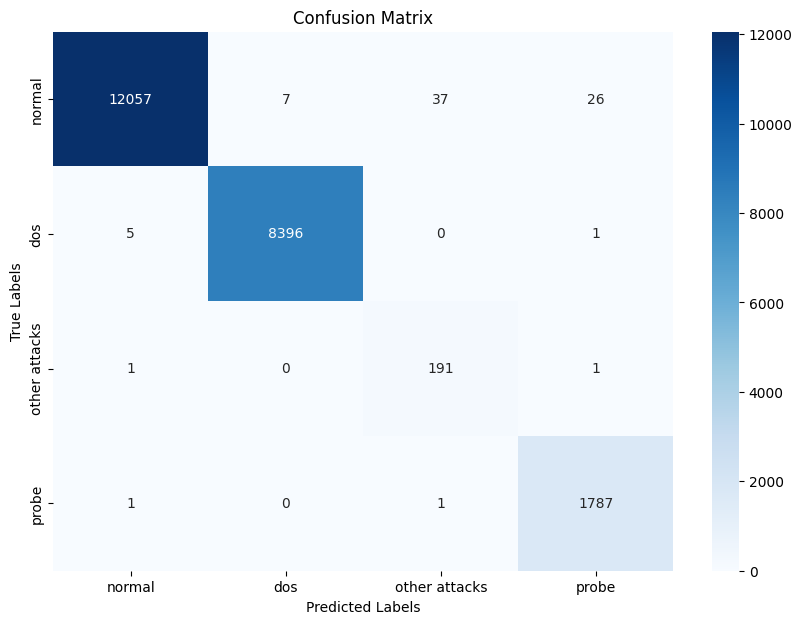

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.99      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.83      0.99      0.91       193
        probe       0.98      1.00      0.99      1789

     accuracy                           1.00     22511
    macro avg       0.95      1.00      0.97     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.996446181866643
NDCG score with 1st 2 relevant ranks: 0.9985482533658149
============Fold 2=============
==========================Train metrics================================


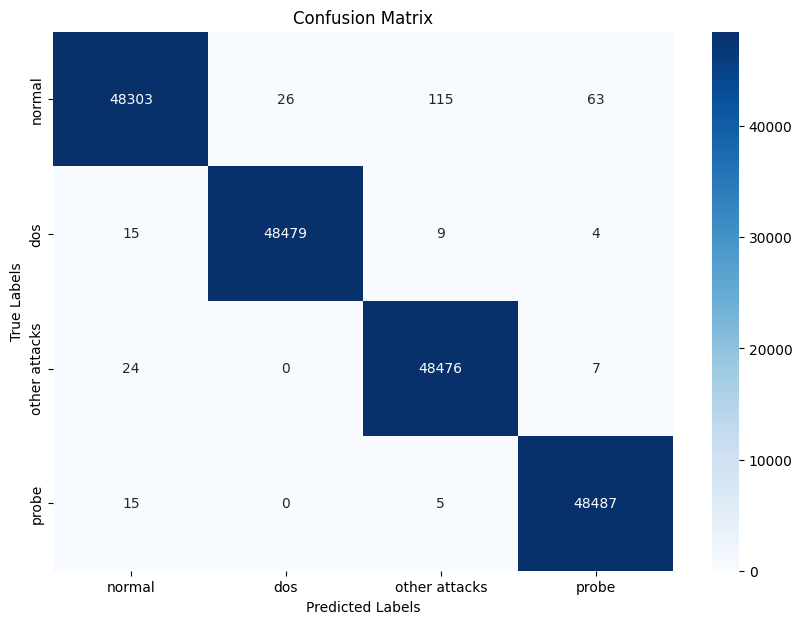

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9985414476261159
NDCG score with 1st 2 relevant ranks: 0.9993478806094263
==========================Val metrics================================


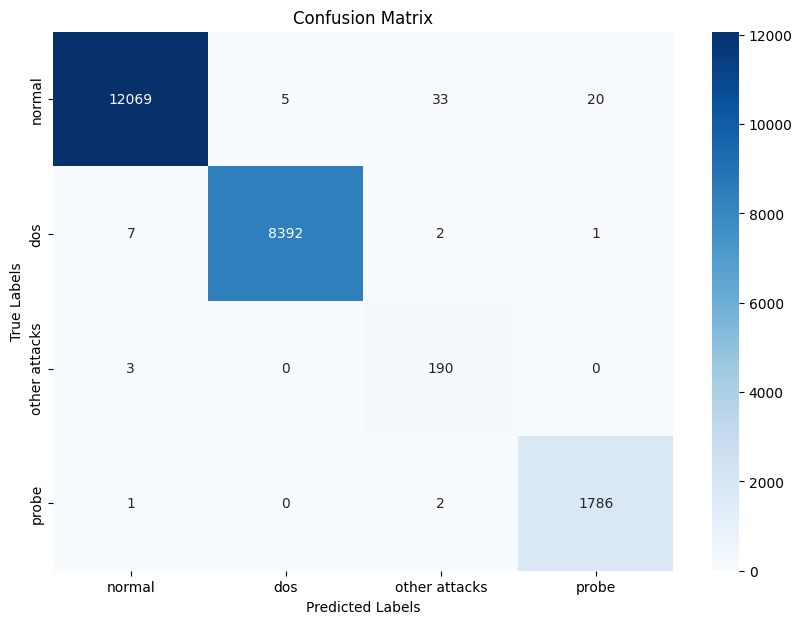

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.84      0.98      0.90       193
        probe       0.99      1.00      0.99      1789

     accuracy                           1.00     22511
    macro avg       0.96      0.99      0.97     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9967127182266448
NDCG score with 1st 2 relevant ranks: 0.998506485905938
============Fold 3=============
==========================Train metrics================================


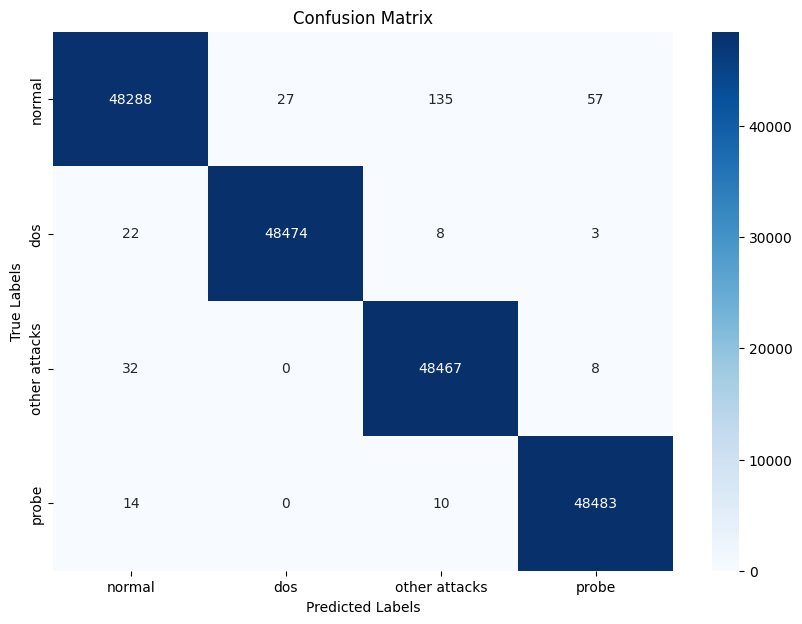

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9983713690807512
NDCG score with 1st 2 relevant ranks: 0.9993046201541785
==========================Val metrics================================


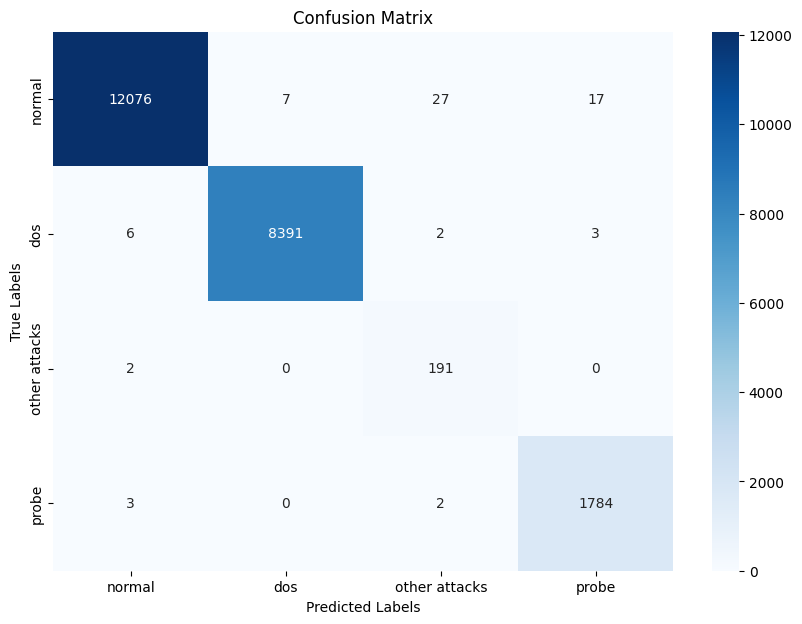

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.86      0.99      0.92       193
        probe       0.99      1.00      0.99      1789

     accuracy                           1.00     22511
    macro avg       0.96      1.00      0.98     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9969348318599796
NDCG score with 1st 2 relevant ranks: 0.9984483233393833
============Fold 4=============
==========================Train metrics================================


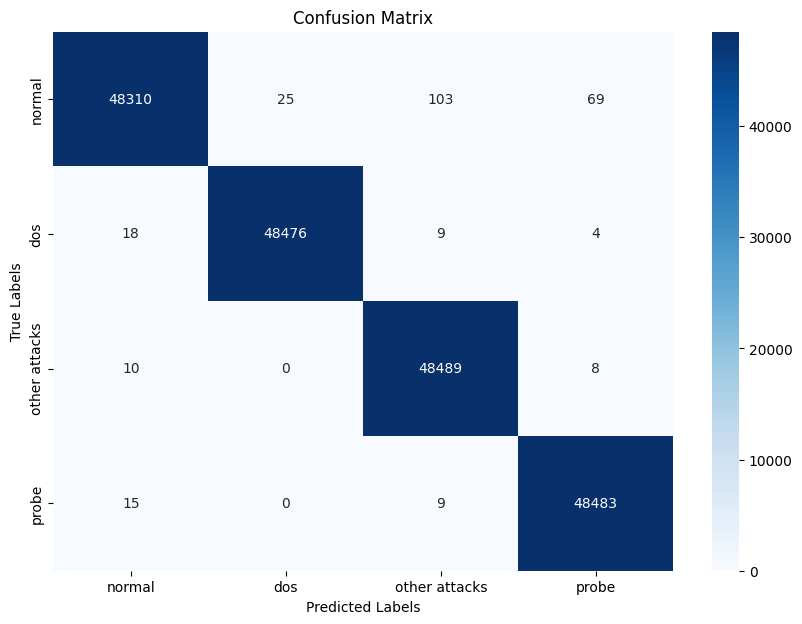

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9986084482651988
NDCG score with 1st 2 relevant ranks: 0.9993758602977038
==========================Val metrics================================


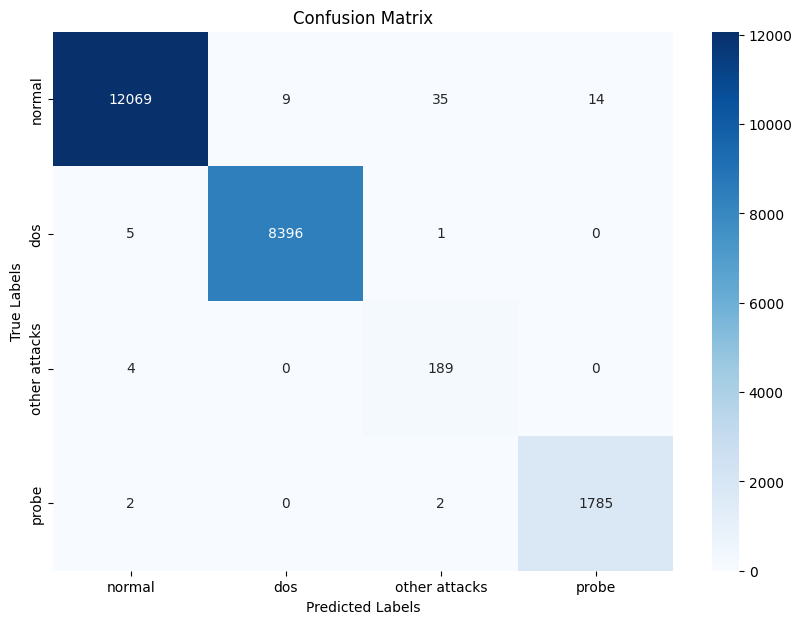

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.83      0.98      0.90       193
        probe       0.99      1.00      0.99      1789

     accuracy                           1.00     22511
    macro avg       0.96      0.99      0.97     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9968015636799786
NDCG score with 1st 2 relevant ranks: 0.9985112484993052
============Fold 5=============
==========================Train metrics================================


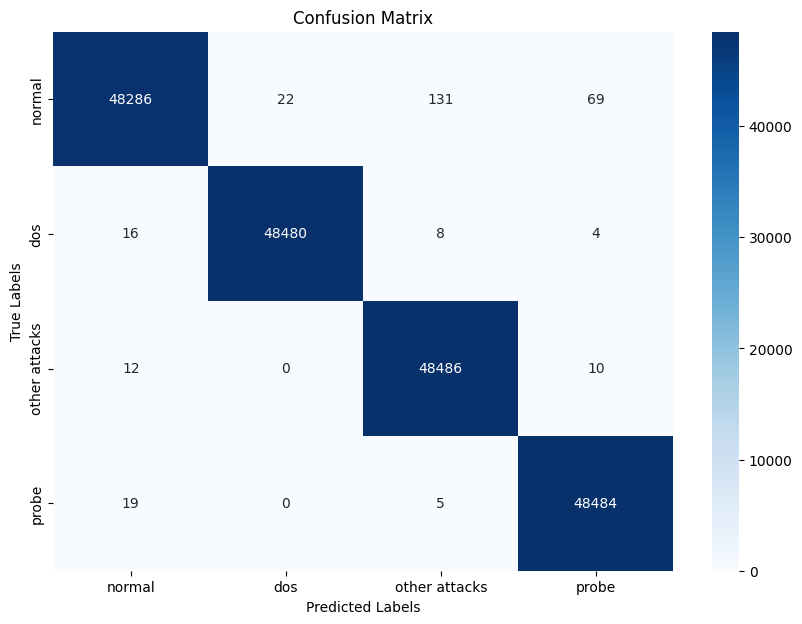

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48508
          dos       1.00      1.00      1.00     48508
other attacks       1.00      1.00      1.00     48508
        probe       1.00      1.00      1.00     48508

     accuracy                           1.00    194032
    macro avg       1.00      1.00      1.00    194032
 weighted avg       1.00      1.00      1.00    194032

Accuracy: 0.9984744784365466
NDCG score with 1st 2 relevant ranks: 0.9993329216569576
==========================Val metrics================================


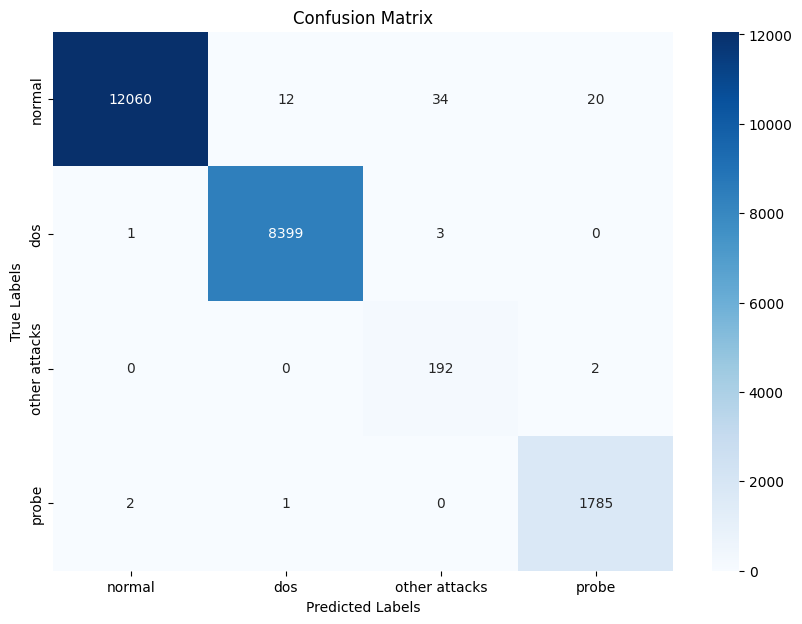

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.99      1.00     12126
          dos       1.00      1.00      1.00      8403
other attacks       0.84      0.99      0.91       194
        probe       0.99      1.00      0.99      1788

     accuracy                           1.00     22511
    macro avg       0.96      1.00      0.97     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9966682954999778
NDCG score with 1st 2 relevant ranks: 0.9983499526993151
==========================End of Folds================================
time taken(mins):  3.1145255605379742
param_dict[best_estimator]:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', impo

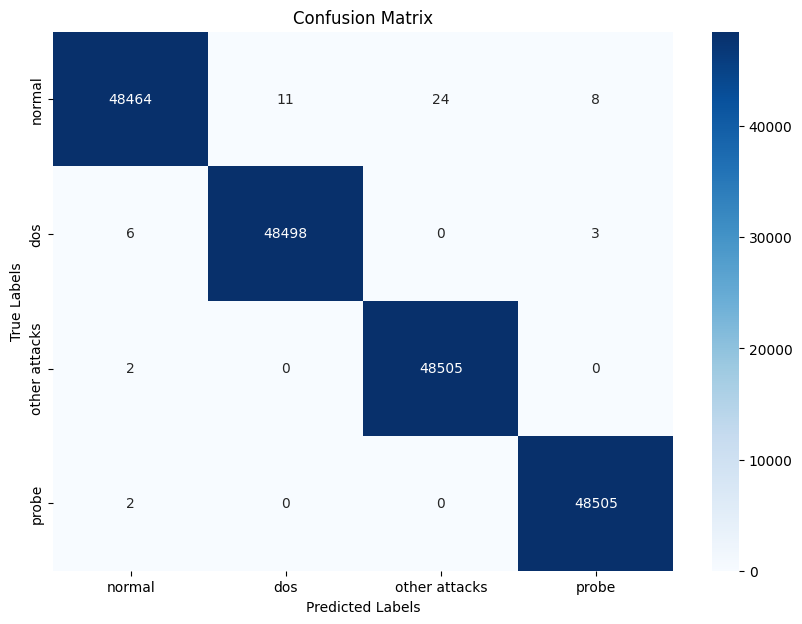

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9997113818624116
NDCG score with 1st 2 relevant ranks: 0.9998804726492346
==========================Val metrics================================


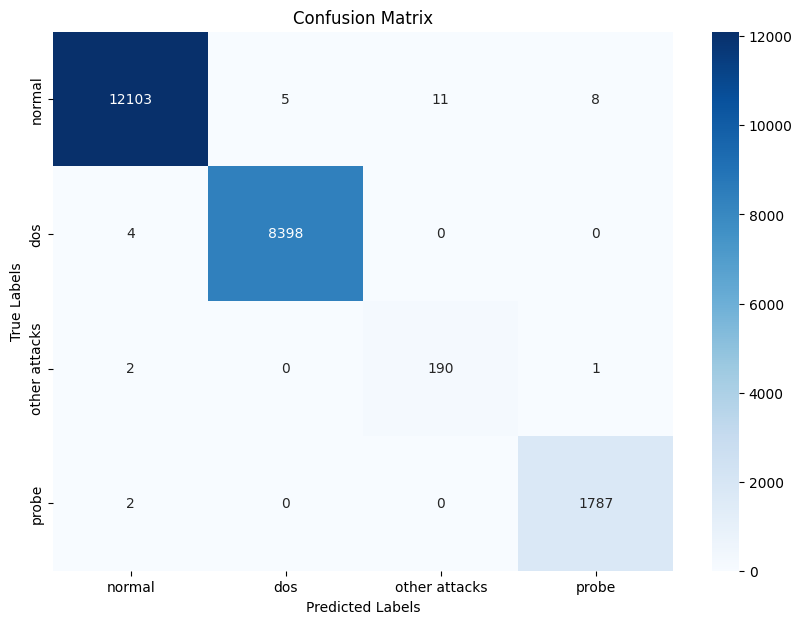

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.95      0.98      0.96       193
        probe       0.99      1.00      1.00      1789

     accuracy                           1.00     22511
    macro avg       0.98      1.00      0.99     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9985340500199902
NDCG score with 1st 2 relevant ranks: 0.9993748786196589
============Fold 2=============
==========================Train metrics================================


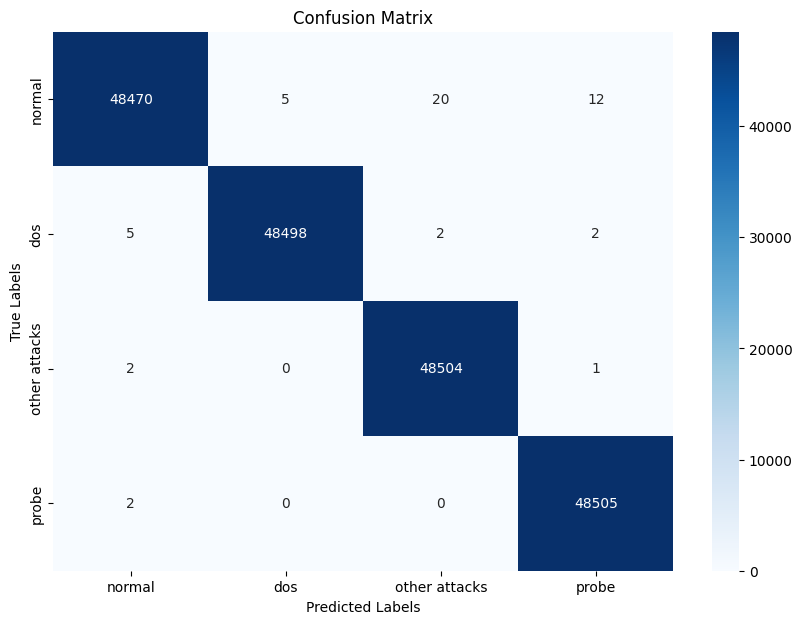

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.999737151338982
NDCG score with 1st 2 relevant ranks: 0.9998964868881038
==========================Val metrics================================


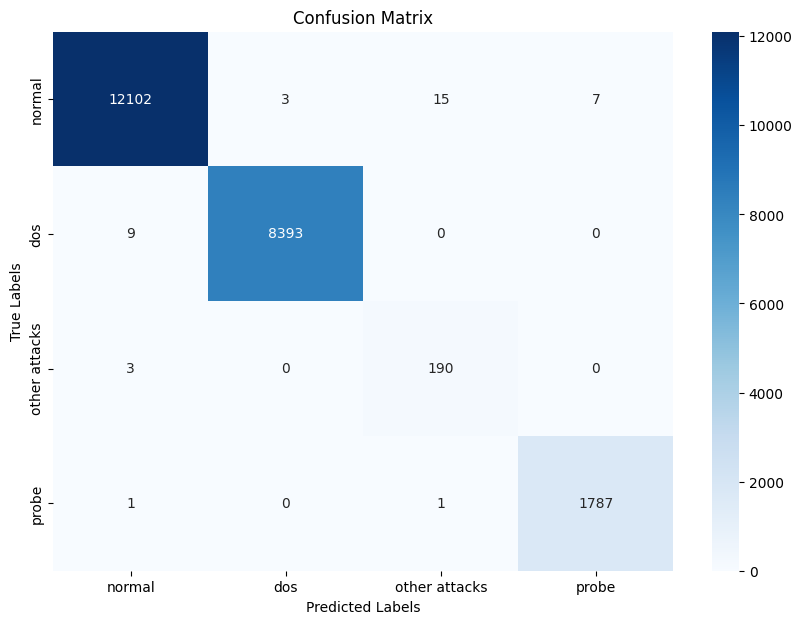

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.92      0.98      0.95       193
        probe       1.00      1.00      1.00      1789

     accuracy                           1.00     22511
    macro avg       0.98      1.00      0.99     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9982675136599884
NDCG score with 1st 2 relevant ranks: 0.9993045355995799
============Fold 3=============
==========================Train metrics================================


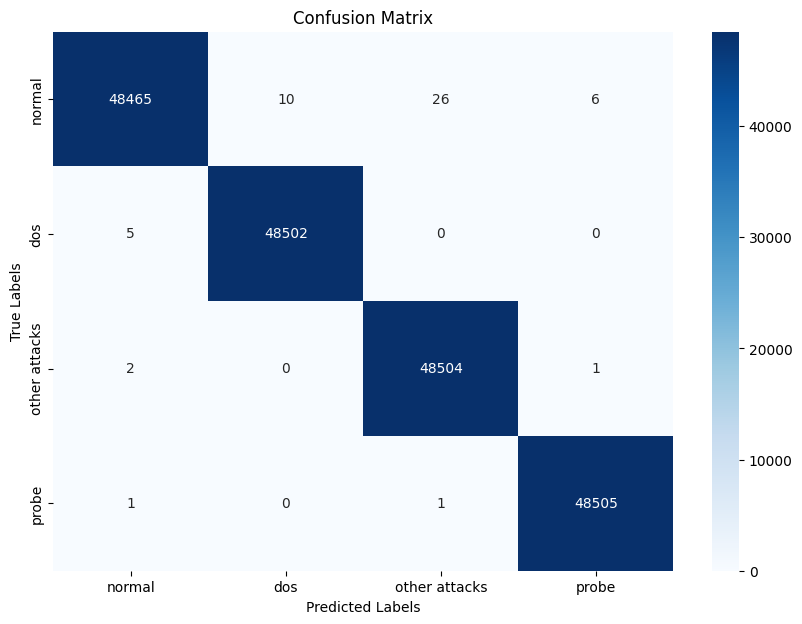

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9997319974436679
NDCG score with 1st 2 relevant ranks: 0.9998945847386901
==========================Val metrics================================


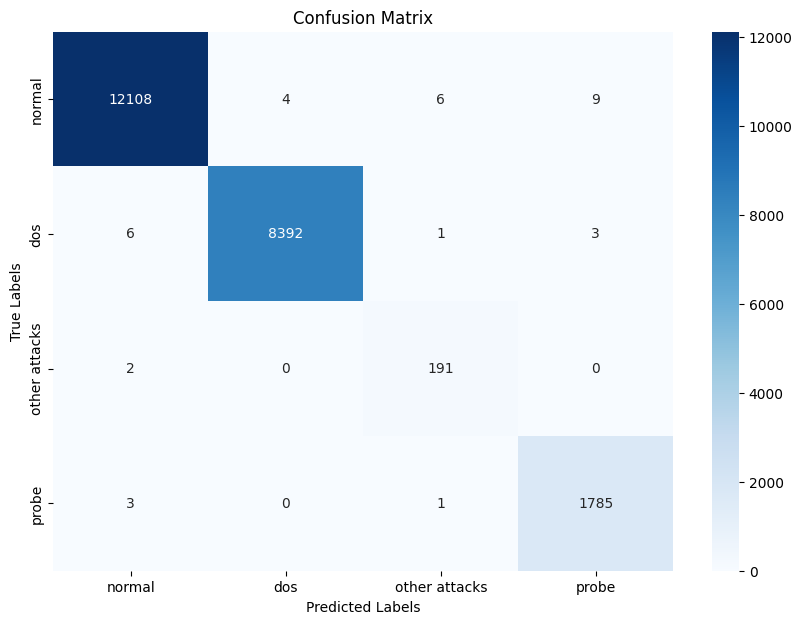

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.96      0.99      0.97       193
        probe       0.99      1.00      1.00      1789

     accuracy                           1.00     22511
    macro avg       0.99      1.00      0.99     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9984452045666563
NDCG score with 1st 2 relevant ranks: 0.999286033166325
============Fold 4=============
==========================Train metrics================================


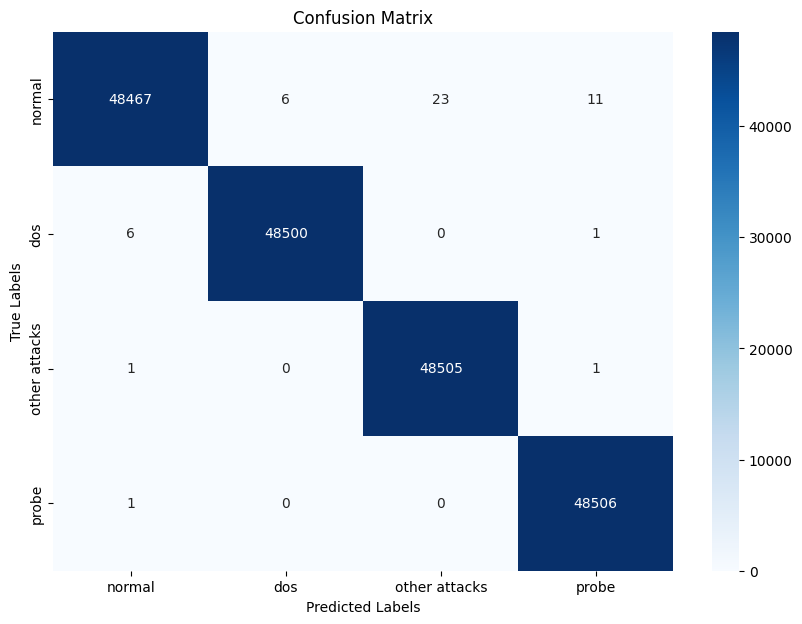

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48507
          dos       1.00      1.00      1.00     48507
other attacks       1.00      1.00      1.00     48507
        probe       1.00      1.00      1.00     48507

     accuracy                           1.00    194028
    macro avg       1.00      1.00      1.00    194028
 weighted avg       1.00      1.00      1.00    194028

Accuracy: 0.9997423052342961
NDCG score with 1st 2 relevant ranks: 0.9998918855457165
==========================Val metrics================================


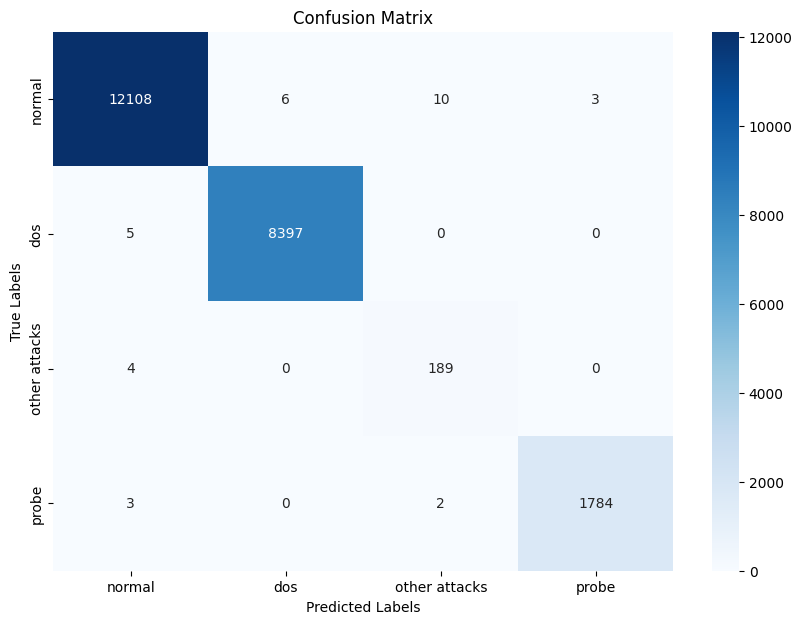

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12127
          dos       1.00      1.00      1.00      8402
other attacks       0.94      0.98      0.96       193
        probe       1.00      1.00      1.00      1789

     accuracy                           1.00     22511
    macro avg       0.98      0.99      0.99     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9985340500199902
NDCG score with 1st 2 relevant ranks: 0.9993748786196589
============Fold 5=============
==========================Train metrics================================


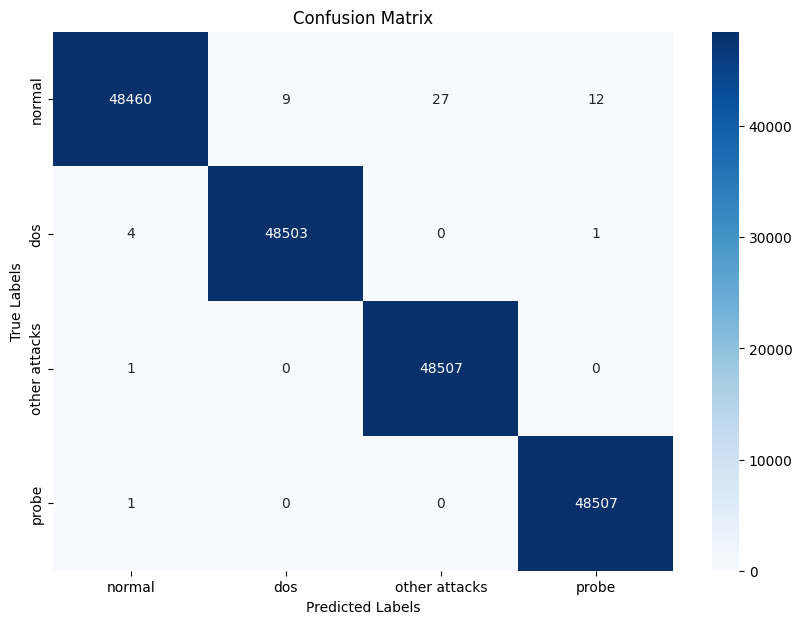

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     48508
          dos       1.00      1.00      1.00     48508
other attacks       1.00      1.00      1.00     48508
        probe       1.00      1.00      1.00     48508

     accuracy                           1.00    194032
    macro avg       1.00      1.00      1.00    194032
 weighted avg       1.00      1.00      1.00    194032

Accuracy: 0.9997165416013853
NDCG score with 1st 2 relevant ranks: 0.9998921322601056
==========================Val metrics================================


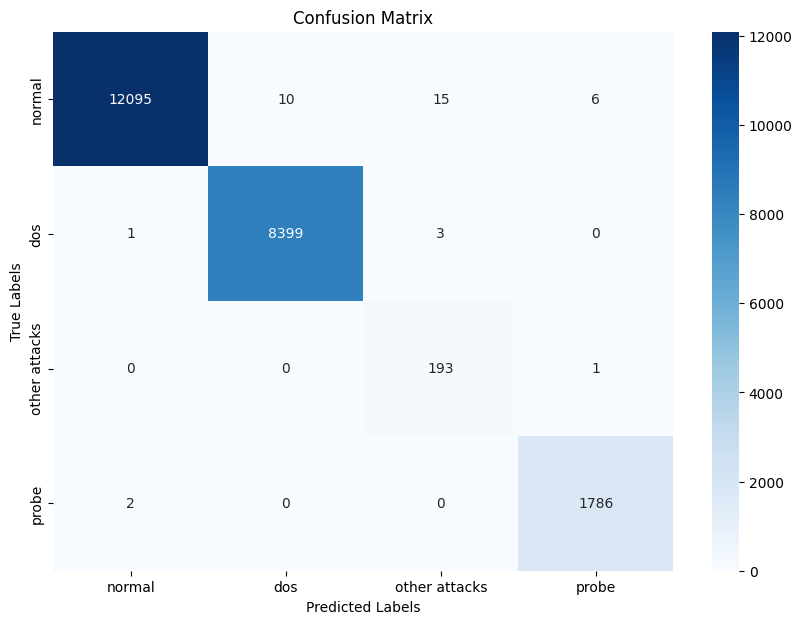

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      1.00      1.00     12126
          dos       1.00      1.00      1.00      8403
other attacks       0.91      0.99      0.95       194
        probe       1.00      1.00      1.00      1788

     accuracy                           1.00     22511
    macro avg       0.98      1.00      0.99     22511
 weighted avg       1.00      1.00      1.00     22511

Accuracy: 0.9983119363866554
NDCG score with 1st 2 relevant ranks: 0.9991527649863241
==========================End of Folds================================
time taken(mins):  3.1011914292971294
param_dict[best_estimator]:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', impo

In [17]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb

param=[
        
    {
    'classifier':[RandomForestClassifier()],
        'classifier__n_estimators':[200],
        'classifier__max_depth':[3,5],
        #'classifier__min_samples_split':[2,5,10],
        #'classifier__min_samples_leaf':[1,2,4],
        'classifier__bootstrap':[True],
        'classifier__oob_score':[True]

    }

    ,
    {
    'classifier':[xgb.XGBClassifier(use_label_encoder=False)],
    'classifier__n_estimators':[200],
    'classifier__learning_rate':[0.1,0.2],
    'classifier__max_depth':[3],
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[1.0],
    'classifier__eval_metric':['mlogloss']

    }

    ]

estimator_pkl='best_estimator.pkl'

find_best_model(estimator_pkl,xtrain,ytrain,xtest,ytest,5,True)

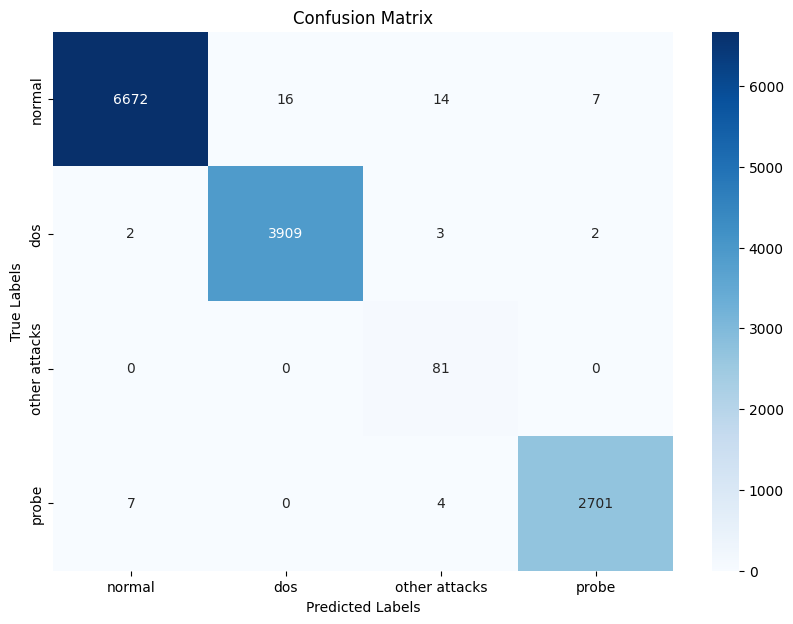

Classification Report:
               precision    recall  f1-score   support

       normal       1.00      0.99      1.00      6709
          dos       1.00      1.00      1.00      3916
other attacks       0.79      1.00      0.89        81
        probe       1.00      1.00      1.00      2712

     accuracy                           1.00     13418
    macro avg       0.95      1.00      0.97     13418
 weighted avg       1.00      1.00      1.00     13418

Accuracy: 0.9959010284692205
NDCG score with 1st 2 relevant ranks: 0.998111022389168


(0.9959010284692205, 0.998111022389168)

In [18]:
param_dict=pickle.load(open(estimator_pkl,'rb'))
estimator=param_dict['best_estimator']

y_pred_probs=pd.DataFrame(estimator.predict_proba(xtest),columns=estimator.classes_)

ytest=pd.get_dummies(ytest).astype(int)

accuracy_checks(ytest,y_pred_probs)


Feature importances:


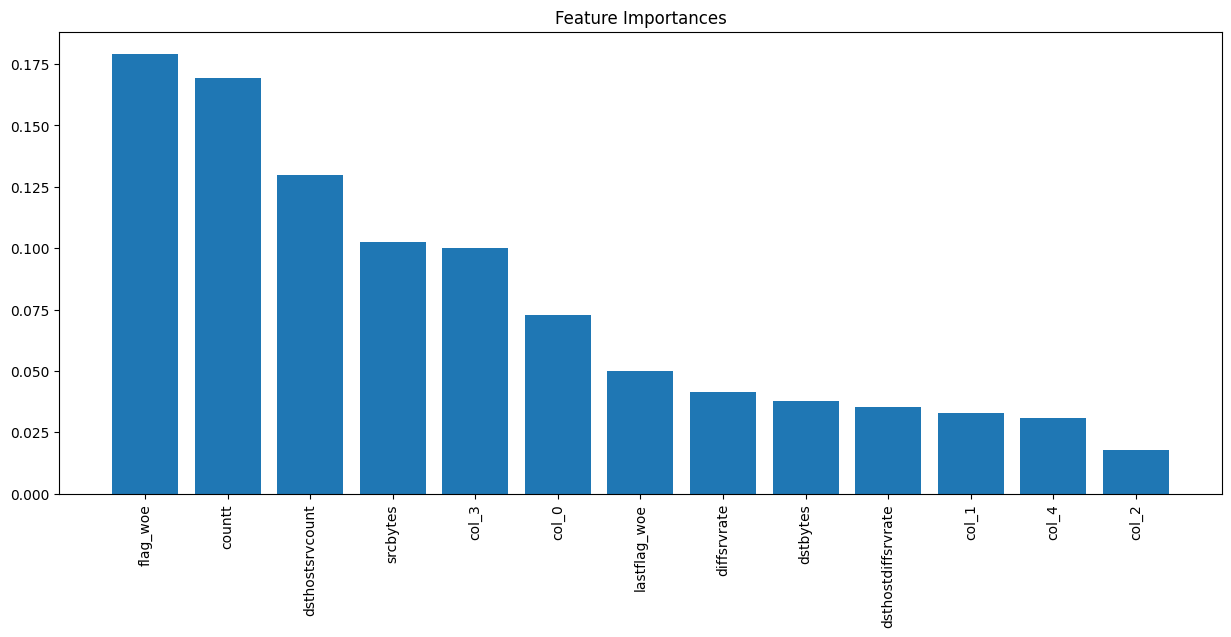

In [19]:
# Retrieve feature importances or equivalent
if hasattr(estimator, 'feature_importances_'):
    importances = estimator.feature_importances_
    print("Feature importances:")
    #print(importances)
elif hasattr(estimator, 'coef_'):
    importances = best_classifier.coef_
    print("Model coefficients:")
    print(importances)
else:
    print("The best classifier does not provide feature importances or coefficients.")

# Optional: visualize feature importances if available
if 'importances' in locals():

    feature_names = xtrain.columns if hasattr(xtrain, 'columns') else np.arange(xtrain.shape[1])
    sorted_indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
    plt.title('Feature Importances')
    plt.show()

In [20]:
param_dict['outlier_dict']=outlier_dict
param_dict['drop_cols']=drop_cols
param_dict['numeric_cols']=numeric_cols
param_dict['scalar']=scalar
param_dict['target_encode']=target_encode
param_dict['rev_target_encode']=rev_target_encode

param_dict['pca']=pca
param_dict['non_imp_features_transformed']=non_imp_features_transformed
param_dict['imp_features_transformed']=imp_features_transformed


pickle.dump(param_dict,open(estimator_pkl,'wb'))